#### 本Notebookは書籍『Pythonで動かして学ぶ！Kaggleデータ分析入門』(翔泳社, 2020)の内容のサンプルコードとなります。

本書には記載していないコードですが、ここから実行してください

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 4.3　データを取得する

#### 必要なライブラリをインポートする

リスト4.1 matplotlibとseabornのインポートとグラフ描画の設定

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache using fc-list. This may take a moment.


In [5]:
plt.style.use("ggplot")

リスト4.2　pandas、NumPyのインポート

In [6]:
import pandas as pd
import numpy as np

#### ランダムシードの設定

リスト4.3　ランダムシードを設定

In [7]:
import random
np.random.seed(1234)
random.seed(1234)

#### CSVデータを読み込む（Kaggleの場合）

リスト4.5　CSVデータの読み込み（Kaggleの場合）

In [182]:
#リビングPC
train_df = pd.read_csv("/home/ki-mu-ra/デスクトップ/勉強/kagukagu/SIFNATE_house_price/train.csv")
test_df = pd.read_csv("/home/ki-mu-ra/デスクトップ/勉強/kagukagu/SIFNATE_house_price/test.csv")
submission = pd.read_csv("/home/ki-mu-ra/デスクトップ/勉強/kagukagu/SIFNATE_house_price/sample_submit.csv")

In [10]:
#会社PC
train_df = pd.read_csv("/home/kimu/デスクトップ/kagukagu/SIFNATE_house_price/train.csv")
test_df = pd.read_csv("/home/kimu/デスクトップ/kagukagu/SIFNATE_house_price/test.csv")
submission = pd.read_csv("/home/kimu/デスクトップ/kagukagu/SIFNATE_house_price/sample_submit.csv")

In [183]:
submission.tail()

,no,mone
1995,3138,100000
1996,191,100000
1997,3294,100000
1998,3073,100000
1999,361,100000


In [184]:
train_df.head()

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,...,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,200,2163,20,RL,9000,Reg,Lvl,Inside,NAmes,1Fam,...,1.998003,381.014258,Y,0,0,7,2007,WD,Normal,158000
1,3832,1862,20,RL,9600,Reg,Lvl,Inside,CollgCr,1Fam,...,1.998003,384.114652,Y,0,0,11,2007,WD,Normal,145000
2,4927,754,20,RL,9600,Reg,Lvl,Inside,NridgHt,1Fam,...,2.998015,625.140330,Y,0,0,5,2008,WD,Normal,125000
3,4088,641,80,RL,9600,Reg,Lvl,Inside,OldTown,1Fam,...,0.998002,193.156275,Y,0,0,7,2006,WD,Normal,135000
4,3644,754,20,RL,9600,Reg,Lvl,Inside,NoRidge,1Fam,...,2.998012,617.903766,Y,0,0,7,2007,WD,Normal,175000


## 4.4 ベースライン（ベンチマーク）を作成する

### LightGBMで予測する

#### 学習データの各変数の型を確認する

リスト4.6　各変数の型の確認

In [185]:
train_df.dtypes

index               int64
Order               int64
MS SubClass         int64
MS Zoning          object
Lot Area            int64
Lot Shape          object
Land Contour       object
Lot Config         object
Neighborhood       object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Exterior 1st       object
Exterior 2nd       object
Exter Qual         object
Foundation         object
BsmtFin SF 1      float64
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Heating QC         object
Central Air        object
Electrical         object
1st Flr SF          int64
2nd Flr SF          int64
Gr Liv Area         int64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Full Bath           int64
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Fireplaces  

リスト4.7　MSZoningの各分類ごとの個数を確認する

In [190]:
train_df["Kitchen Qual"].value_counts()

TA    2040
Gd     926
Ex      34
Name: Kitchen Qual, dtype: int64

### 学習データとテストデータを連結して前処理を行う

リスト4.8　学習データとテストデータの連結

In [191]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [192]:
all_df

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,...,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,200,2163,20,RL,9000,Reg,Lvl,Inside,NAmes,1Fam,...,1.998003,381.014258,Y,0,0,7,2007,WD,Normal,158000.0
1,3832,1862,20,RL,9600,Reg,Lvl,Inside,CollgCr,1Fam,...,1.998003,384.114652,Y,0,0,11,2007,WD,Normal,145000.0
2,4927,754,20,RL,9600,Reg,Lvl,Inside,NridgHt,1Fam,...,2.998015,625.140330,Y,0,0,5,2008,WD,Normal,125000.0
3,4088,641,80,RL,9600,Reg,Lvl,Inside,OldTown,1Fam,...,0.998002,193.156275,Y,0,0,7,2006,WD,Normal,135000.0
4,3644,754,20,RL,9600,Reg,Lvl,Inside,NoRidge,1Fam,...,2.998012,617.903766,Y,0,0,7,2007,WD,Normal,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3138,2447,120,RL,3907,IR1,Lvl,Inside,StoneBr,1Fam,...,1.998003,641.261977,Y,0,0,6,2007,WD,Normal,NaN
4996,191,27,120,RL,3907,IR1,Lvl,Inside,Mitchel,1Fam,...,1.998007,387.032024,Y,0,0,7,2008,WD,Normal,NaN
4997,3294,208,50,RL,6000,Reg,Lvl,Inside,Crawfor,1Fam,...,1.998007,406.608942,Y,0,0,7,2009,WD,Normal,NaN
4998,3073,1293,120,RL,1680,Reg,Lvl,Inside,Edwards,1Fam,...,-0.001999,-0.001395,Y,0,0,6,2009,WD,Normal,NaN


リスト4.9　目的変数であるSalePriceの値を確認

In [193]:
all_df["SalePrice"]

0       158000.0
1       145000.0
2       125000.0
3       135000.0
4       175000.0
          ...   
4995         NaN
4996         NaN
4997         NaN
4998         NaN
4999         NaN
Name: SalePrice, Length: 5000, dtype: float64

#### カテゴリ変数を数値に変換する

リスト4.10　LabelEncoderのライブラリをインポート

In [194]:
from sklearn.preprocessing import LabelEncoder

リスト4.11　object型の変数を取得

In [195]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Paved Drive', 'Sale Type',
       'Sale Condition'],
      dtype='object')


リスト4.12　'Alley'の各分類の個数を確認

#### 欠損値を数値に変換する

リスト4.13　欠損値を数値に変換

In [196]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MS Zoning
Lot Shape
Land Contour
Lot Config
Neighborhood
Bldg Type
House Style
Roof Style
Exterior 1st
Exterior 2nd
Exter Qual
Foundation
Heating QC
Central Air
Electrical
Kitchen Qual
Paved Drive
Sale Type
Sale Condition


In [197]:
all_df

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,...,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,200,2163,20,1,9000,1,2,2,11,0,...,1.998003,381.014258,1,0,0,7,2007,1,0,158000.0
1,3832,1862,20,1,9600,1,2,2,4,0,...,1.998003,384.114652,1,0,0,11,2007,1,0,145000.0
2,4927,754,20,1,9600,1,2,2,15,0,...,2.998015,625.140330,1,0,0,5,2008,1,0,125000.0
3,4088,641,80,1,9600,1,2,2,16,0,...,0.998002,193.156275,1,0,0,7,2006,1,0,135000.0
4,3644,754,20,1,9600,1,2,2,14,0,...,2.998012,617.903766,1,0,0,7,2007,1,0,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3138,2447,120,1,3907,0,2,2,20,0,...,1.998003,641.261977,1,0,0,6,2007,1,0,NaN
4996,191,27,120,1,3907,0,2,2,10,0,...,1.998007,387.032024,1,0,0,7,2008,1,0,NaN
4997,3294,208,50,1,6000,1,2,2,5,0,...,1.998007,406.608942,1,0,0,7,2009,1,0,NaN
4998,3073,1293,120,1,1680,1,2,2,6,0,...,-0.001999,-0.001395,1,0,0,6,2009,1,0,NaN


#### 再び学習データとテストデータに戻す

リスト4.14　データをtrain_dfとtest_dfに戻す

In [198]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

#### LightGBMに上記データを読み込ませる

リスト4.15　LightGBMのライブラリをインポート

In [11]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

### クロスバリデーションを用いてモデルの学習・予測を行う

#### クロスバリデーション用のライブラリを読み込んで分割数を設定する

リスト4.16　クロスバリデーション用のライブラリを読み込んで分割数を3に設定

In [200]:
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

#### ハイパーパラメータを設定する

リスト4.17　LightGBMのハイパーパラメータを設定

In [201]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

#### 説明変数、目的変数を指定する

リスト4.18　説明変数、目的変数を指定

In [202]:
train_X = train_df_le.drop(["SalePrice", "index"], axis=1)
train_Y = train_df_le["SalePrice"]

#### 平均二乗誤差を出すライブラリをインポートする

リスト4.19　平均二乗誤差を出すライブラリをインポート

In [203]:
from sklearn.metrics import mean_squared_error

#### 各foldごとに作成したモデルごとの予測値を保存する

リスト4.20　各foldごとに作成したモデルごとの予測値を保存

In [204]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 40
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 150231.774000
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 8.52766e+08
[20]	valid_0's l2: 8.10026e+08
[30]	valid_0's l2: 8.00821e+08
[40]	valid_0's l2: 8.02157e+08
[50]	valid_0's l2: 7.99542e+08
[60]	valid_0's l2: 8.0316e+08
Early stopping, best iteration is:
[46]	valid_0's l2: 7.97319e+08
0.16866375739199765
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [War

#### 平均RMSEを計算する

リスト4.21　平均RMSEを計算

In [205]:
sum(rmses)/len(rmses)

0.1654126611824661

#### 現状の予測値と実際の値の違いを確認する

リスト4.23　現状の予測値と実際の値の違いを可視化

In [206]:
actual_pred_df = pd.DataFrame({
"actual" : train_Y,
"pred" : oof })

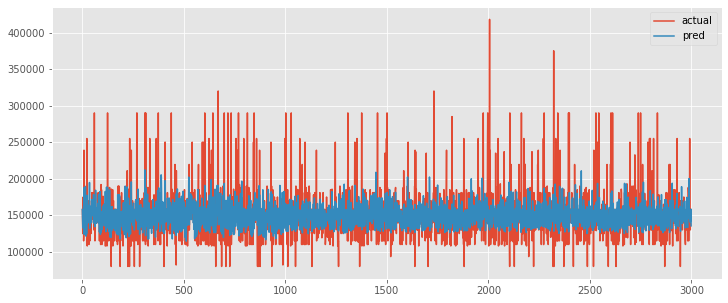

In [207]:
actual_pred_df.plot(figsize=(12,5))

### 各変数の重要度を確認する

#### 表示する変数の数を制限する

リスト4.24　変数の数を制限して各変数の重要度を表示

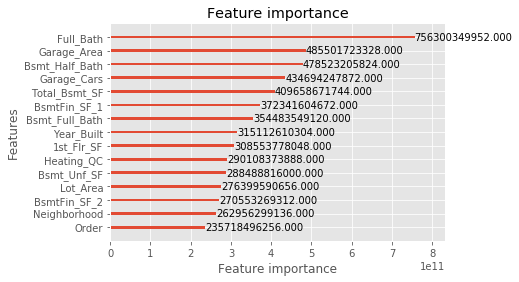

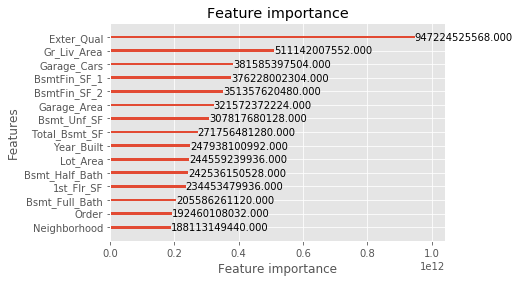

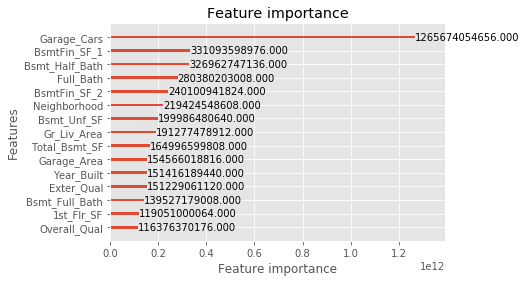

In [208]:
for model in models:
    lgb.plot_importance(model,importance_type="gain", max_num_features=15)

## 4.5　目的変数の前処理：目的変数の分布を確認する

### SalePriceのデータの分布を確認する

#### SalePriceの各統計量を確認する

リスト4.25　SalePriceの各統計量を確認

In [209]:
train_df["SalePrice"].describe()

count      3000.000000
mean     150288.542000
std       31054.043412
min       80000.000000
25%      139000.000000
50%      145000.000000
75%      158000.000000
max      418000.000000
Name: SalePrice, dtype: float64

#### ヒストグラムでSalePriceの分布を確認する

リスト4.26　ヒストグラムで分布を確認

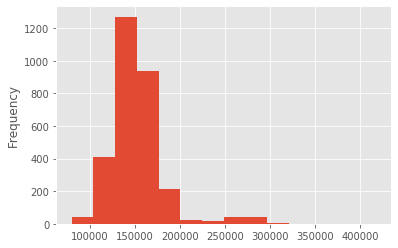

In [210]:
train_df["SalePrice"].plot.hist(bins=14)

#### 目的変数を対数化する

リスト4.27　SalePriceを対数化

In [211]:
np.log(train_df['SalePrice'])

0       11.970350
1       11.884489
2       11.736069
3       11.813030
4       12.072541
          ...    
2995    11.775290
2996    11.849398
2997    11.970350
2998    11.970350
2999    11.938193
Name: SalePrice, Length: 3000, dtype: float64

リスト4.28　対数化したSalePriceの分布をヒストグラムで可視化

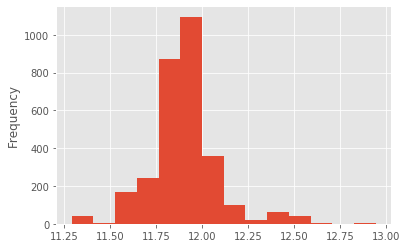

In [212]:
np.log(train_df['SalePrice']).plot.hist(bins=14)

#### 目的変数の対数化による予測精度の向上を確認する

リスト4.29　対数化による予測精度の向上を確認

In [213]:
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [214]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","index"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [215]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 40
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.902257
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0307256
[20]	valid_0's l2: 0.0288929
[30]	valid_0's l2: 0.0284931
[40]	valid_0's l2: 0.0287158
Early stopping, best iteration is:
[29]	valid_0's l2: 0.0284794
0.16875841960380789
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0

In [216]:
sum(rmses)/len(rmses)

0.16372587375041384

In [217]:
print("------------------------------------------")

------------------------------------------


## 4.6　説明変数の前処理：欠損値を確認する

### 各説明変数の欠損値を確認する

#### all_dfを作成する

リスト4.30　all_dfの作成

In [36]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [37]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


#### 欠損値の数が上位40の変数を確認する

リスト4.31　欠損値の数が上位40の変数を確認

In [38]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageArea         1
BsmtFinSF2         1
Exterior1st        1
TotalBsmtSF        1
GarageCars         1
BsmtUnfSF          1
Electrical         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
Exterior2nd        1
Street             0
RoofMatl           0
MSSubClass         0
LotArea            0
OverallCond        0
dtype: int64

#### 欠損値の多い高級住宅設備に関する変数をまとめる

リスト4.32　PoolQCの各分類ごとの個数

In [39]:
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

リスト4.33　PoolQCの値を値があるものを1、値がないものを0に変換

In [40]:
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

リスト4.34　0か1の値を持つ項目になったかを確認

In [41]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

リスト4.35　MiscFeature、Alleyも0と1に変換する

In [42]:
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0

In [43]:
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

リスト4.36　繰り返し処理はfor文でまとめる

In [44]:
HighFacility_col = ["PoolQC","MiscFeature","Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

リスト4.37　0か1の値に変換した各変数を足し合わせて、高級住宅設備の数という特徴量を作成

In [45]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]

In [46]:
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

リスト4.38　高級住宅設備の数ごとの家の数を確認

In [47]:
all_df["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

リスト4.39　もとのデータからPoolQC、MiscFeature、Alleyを削除

In [48]:
all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

## 4.7 外れ値を除外する

### 各説明変数のデータの分布を確認する

#### 各変数の統計量を確認する

リスト4.40　各変数の統計量を確認

In [49]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


#### 数値データのみを抜き出す

リスト4.41　数値データのみの抜き出し

In [50]:
train_df_num = train_df.select_dtypes(include=[np.number])

リスト4.42　比例尺度ではない変数

In [51]:
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

リスト4.43　数値データからリスト4.43の変数を除いた比例尺度データ

In [52]:
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

In [53]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

リスト4.44　比例尺度の列のみを抜き出す

In [54]:
train_df_num_rs = train_df_num[num_features]

#### 多数のデータが0（ゼロ）の値である変数を確認する

リスト4.45　3/4分位数が0となる変数を確認

In [55]:
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


#### ある特定の値のみを持つ変数を確認する

リスト4.46　ある特定の値のみしかとらないものを確認

In [56]:
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


#### 外れ値があるか確認する

リスト4.47　外れ値があるか確認

In [57]:
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
    (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


#### 外れ値を含む変数の分布を可視化する

リスト4.48　BsmtFinSF1とSalePriceの分布を可視化

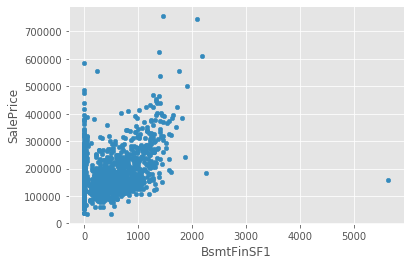

In [58]:
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

リスト4.49　BsmtFinSF1が広いもののSalePriceが高くないものを確認

In [59]:
all_df[all_df["BsmtFinSF1"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


リスト4.50　TotalBsmtSFとSalePriceの分布を可視化

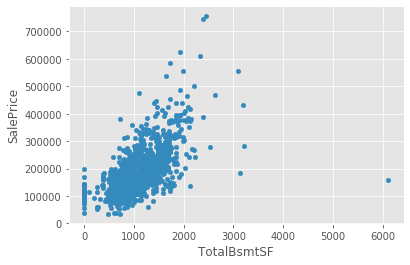

In [60]:
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [61]:
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


リスト4.51　GrLivAreaとSalePriceの分布を可視化

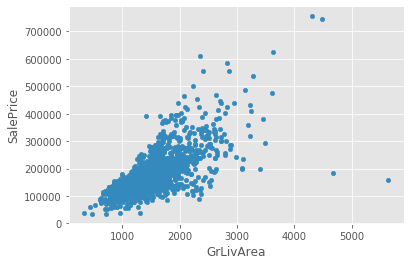

In [62]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [63]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


リスト4.52　1stFlrSFとSalePriceの分布を可視化

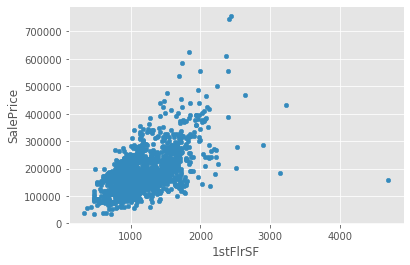

In [64]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [65]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


リスト4.53　外れ値以外を抽出（テストデータはすべて抽出）

In [66]:
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

#### 前処理した学習データでRMSEを計算する

リスト4.54　categoriesの中から除外した3つの変数を削除

In [67]:
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

リスト4.55　欠損値をmissingに置き換えてall_dfのカテゴリ変数をcategoryに指定

In [68]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


リスト4.56　train_df_leとtest_df_leに分割

In [69]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [70]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0424478
[20]	valid_0's l2: 0.0222118
[30]	valid_0's l2: 0.0175757
[40]	valid_0's l2: 0.0165142
[50]	valid_0's l2: 0.0164264
[60]	valid_0's l2: 0.016285
[70]	valid_0's l2: 0.0163922
[80]	valid_0's l2: 0.0163238
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0162509
0.12745948164738202
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.047333
[20]	valid_0's l2: 0.0272932
[30]	valid_0's l2: 0.0223134
[40]	valid_0's l2: 0.0209381
[50]	valid_0's l2: 0.0203039
[60]	valid_0's l2: 0.0200215
[70]	valid_0's l2: 0.0197188
[80]	valid_0's l2: 0.0196559
[90]	valid_0's l2: 0.0195579
[100]	valid_0's l2: 0.0195231
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.0195208
0.13971669031954484
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0368757
[20]	valid_0's l2: 0.0197062
[30]	valid_0's l2: 0.0167971
[40]	valid_0's l2: 0.0158749

In [71]:
sum(rmses)/len(rmses)

0.13039701843269016

## 4.8 　説明変数の確認：特徴量を生成する

#### 時間に関する変数の統計量を確認する

リスト4.57　時間に関する変数の統計量を確認

In [72]:
all_df[["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


#### 時間に関する変数を組み合わせて新たな特徴量を作成する

リスト4.58　特徴量を追加

In [73]:
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [74]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [75]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0427712
[20]	valid_0's l2: 0.0222468
[30]	valid_0's l2: 0.0177147
[40]	valid_0's l2: 0.016571
[50]	valid_0's l2: 0.0161945
[60]	valid_0's l2: 0.0161879
[70]	valid_0's l2: 0.0161968
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0161388
0.12704034420133195
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0474374
[20]	valid_0's l2: 0.027474
[30]	valid_0's l2: 0.0225527
[40]	valid_0's l2: 0.0207551
[50]	valid_0's l2: 0.0202749
[60]	valid_0's l2: 0.0200399
[70]	valid_0's l2: 0.0198921
[80]	valid_0's l2: 0.0198431
[90]	valid_0's l2: 0.0197761
[100]	valid_0's l2: 0.019663
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.019663
0.14022471834012856
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0369248
[20]	valid_0's l2: 0.0195778
[30]	valid_0's l2: 0.016538
[40]	valid_0's l2: 0.0153916
[50]	valid_0's l2: 0.0149941
[

In [76]:
sum(rmses)/len(rmses)

0.12968959614926723

リスト4.59　他の変数を追加

In [77]:
# 販売した年はリノベーションしてから何年経過していたか（リノベーションしていない場合、Age（築年数）と同じ）
#all_df["RmdAge"] = all_df["YrSold"] - all_df["YearRemodAdd"]
# 販売した年はガレージ建築から何年経過していたか
#all_df["GarageAge"] = all_df["YrSold"] - all_df["GarageYrBlt"]
# 築何年たってから、リノベーションしたか
#all_df["RmdTiming"] = all_df["YearRemodAdd"] - all_df["YearBuilt"]

#### 広さ関連の変数から新たな特徴量を作成する

リスト4.60　広さに関する変数の統計量を確認

In [78]:
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


リスト4.61　広さの変数から追加するもの

In [79]:
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

リスト4.62　Porchの広さの合計も特徴量として追加

In [80]:
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

リスト4.63　Porchの広さの合計をPorchがあるかないかの0、1の値に変換

In [81]:
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

リスト4.64　精度を確認

In [82]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [83]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0388049
[20]	valid_0's l2: 0.0199263
[30]	valid_0's l2: 0.0165969
[40]	valid_0's l2: 0.0158728
[50]	valid_0's l2: 0.0157388
[60]	valid_0's l2: 0.015844
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0157164
0.12536497336459065
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0459281
[20]	valid_0's l2: 0.0262784
[30]	valid_0's l2: 0.0217831
[40]	valid_0's l2: 0.0205294
[50]	valid_0's l2: 0.0201039
[60]	valid_0's l2: 0.0198874
[70]	valid_0's l2: 0.019815
[80]	valid_0's l2: 0.0198968
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0197659
0.14059120440349726
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0354828
[20]	valid_0's l2: 0.0183241
[30]	valid_0's l2: 0.0154847
[40]	valid_0's l2: 0.0145868
[50]	valid_0's l2: 0.0143982
[60]	valid_0's l2: 0.0142851
[70]	valid_0's l2: 0.0144113
Early stopping, best iteration is:
[56]	va

In [84]:
sum(rmses)/len(rmses)

0.128396868966143

## 4.9　ハイパーパラメータを最適化する

#### Optunaのライブラリをインストール・インポートする

リスト4.65　Optunaのライブラリのインポート

In [159]:
print("-----")

-----


In [218]:
import optuna

### Optunaを実装する

#### 学習データ、検証データを作成する

リスト4.66　学習データと検証データを作成

In [219]:
from sklearn.model_selection import train_test_split

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

#### ハイパーパラメータを最適化する

リスト4.67　Optunaでハイパーパラメータを最適化する

In [221]:
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,        
        "n_estimators":1000,        
        
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),        
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),                
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,)    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [222]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2020-12-12 17:58:00,392] A new study created in memory with name: no-name-c449f462-1034-42ef-9719-32b62aee960c


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0278048
[20]	valid_0's l2: 0.025836
[30]	valid_0's l2: 0.0252651
[40]	valid_0's l2: 0.0251951
[50]	valid_0's l2: 0.0250984
[60]	valid_0's l2: 0.0252692


[I 2020-12-12 17:58:01,533] Trial 0 finished with value: 0.1581835594867492 and parameters: {'num_leaves': 48, 'max_bin': 97, 'bagging_fraction': 0.7575946831862097, 'bagging_freq': 4, 'feature_fraction': 0.8289728088113784, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.1581835594867492.


Early stopping, best iteration is:
[49]	valid_0's l2: 0.025022
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0283826
[20]	valid_0's l2: 0.0265226
[30]	valid_0's l2: 0.0261576
[40]	valid_0's l2: 0.0257931
[50]	valid_0's l2: 0.0256231
[60]	valid_0's l2: 0.0255388
[70]	valid_0's l2: 0.0254567
[80]	valid_0's l2: 0.0254088


[I 2020-12-12 17:58:02,476] Trial 1 finished with value: 0.1590450243473529 and parameters: {'num_leaves': 23, 'max_bin': 71, 'bagging_fraction': 0.5921908536463499, 'bagging_freq': 8, 'feature_fraction': 0.8458865003910399, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.1581835594867492.


[90]	valid_0's l2: 0.025476
Early stopping, best iteration is:
[74]	valid_0's l2: 0.0252953
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279108
[20]	valid_0's l2: 0.0259719
[30]	valid_0's l2: 0.0253016
[40]	valid_0's l2: 0.0252264
[50]	valid_0's l2: 0.0249756
[60]	valid_0's l2: 0.0249553
[70]	valid_0's l2: 0.0247189
[80]	valid_0's l2: 0.0248764
Early stopping, best iteration is:
[69]	valid_

[I 2020-12-12 17:58:03,722] Trial 2 finished with value: 0.1571821436300121 and parameters: {'num_leaves': 42, 'max_bin': 89, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 9, 'feature_fraction': 0.5963923980504149, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.1571821436300121.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 46
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0289464
[20]	valid_0's l2: 0.0272614
[30]	valid_0's l2: 0.0266408
[40]	valid_0's l2: 0.0263761
[50]	valid_0's l2: 0.0263961
[60]	valid_0's l2: 0.0263622
[70]	valid_0's l2: 0.0262599
[80]	valid_0's l2: 0.0262813
[90]	valid_0's l2: 0.0259773


[I 2020-12-12 17:58:04,653] Trial 3 finished with value: 0.1609558072352197 and parameters: {'num_leaves': 13, 'max_bin': 198, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 4, 'feature_fraction': 0.8785775794765232, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 2 with value: 0.1571821436300121.


[100]	valid_0's l2: 0.0262324
[110]	valid_0's l2: 0.0263074
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0259068
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0277058
[20]	valid_0's l2: 0.0258803
[30]	valid_0's l2: 0.0251376
[40]	valid_0's l2: 0.0246606
[50]	valid_0's l2: 0.0243291
[60]	valid_0's l2: 0.0242518
[70]	valid_0's l2: 0.0242987
Early stopping, best iteration is:
[54]	val

[I 2020-12-12 17:58:05,749] Trial 4 finished with value: 0.15558625427771489 and parameters: {'num_leaves': 39, 'max_bin': 79, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 8, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.15558625427771489.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0277589
[20]	valid_0's l2: 0.0255917
[30]	valid_0's l2: 0.0246378
[40]	valid_0's l2: 0.0242763
[50]	valid_0's l2: 0.0245055


[I 2020-12-12 17:58:06,662] Trial 5 finished with value: 0.1555044346950458 and parameters: {'num_leaves': 36, 'max_bin': 81, 'bagging_fraction': 0.4529538035938961, 'bagging_freq': 8, 'feature_fraction': 0.5322778060523135, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.1555044346950458.


[60]	valid_0's l2: 0.0246409
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0241816
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279537
[20]	valid_0's l2: 0.0261641
[30]	valid_0's l2: 0.0256767
[40]	valid_0's l2: 0.0256353
[50]	valid_0's l2: 0.0255087
[60]	valid_0's l2: 0.0254629
[70]	valid_0's l2: 0.0255897


[I 2020-12-12 17:58:08,065] Trial 6 finished with value: 0.15932609202514325 and parameters: {'num_leaves': 59, 'max_bin': 78, 'bagging_fraction': 0.6842169744343243, 'bagging_freq': 1, 'feature_fraction': 0.5620705038966071, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.1555044346950458.


Early stopping, best iteration is:
[56]	valid_0's l2: 0.0253848
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279583
[20]	valid_0's l2: 0.0261797
[30]	valid_0's l2: 0.0254908
[40]	valid_0's l2: 0.0253493
[50]	valid_0's l2: 0.0254228
[60]	valid_0's l2: 0.0253726
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0252828


[I 2020-12-12 17:58:09,284] Trial 7 finished with value: 0.15900557758343245 and parameters: {'num_leaves': 44, 'max_bin': 67, 'bagging_fraction': 0.8718740392573121, 'bagging_freq': 10, 'feature_fraction': 0.6249749949556138, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0295291
[20]	valid_0's l2: 0.0277929
[30]	valid_0's l2: 0.0269016
[40]	valid_0's l2: 0.026404
[50]	valid_0's l2: 0.0260435
[60]	valid_0's l2: 0.0259231
[70]	valid_0's l2: 0.0258573
[80]	valid_0's l2: 0.0257634
[90]	valid_0's l2: 0.0257259
[100]	valid_0's l2: 0.025627
[110]	valid_0's l2: 0.0255916
[120]	valid_0's l2: 0.0255674
[130]	valid_0's l2: 0.0255059
[140]	valid_0's l2: 0.0254614


[I 2020-12-12 17:58:09,959] Trial 8 finished with value: 0.1593478602993071 and parameters: {'num_leaves': 5, 'max_bin': 107, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 8, 'feature_fraction': 0.4854547925680226, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.1555044346950458.


[150]	valid_0's l2: 0.0254852
[160]	valid_0's l2: 0.025432
[170]	valid_0's l2: 0.0254201
[180]	valid_0's l2: 0.0254563
Early stopping, best iteration is:
[168]	valid_0's l2: 0.0253917
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0285158
[20]	valid_0's l2: 0.026611
[30]	valid_0's l2: 0.0258052
[40]	valid_0's l2: 0.0257175
[50]	valid_0's l2: 0.0255259
[60]	valid_0's l2: 0.0255464


[I 2020-12-12 17:58:10,641] Trial 9 finished with value: 0.15966020853065846 and parameters: {'num_leaves': 18, 'max_bin': 149, 'bagging_fraction': 0.5818553854713113, 'bagging_freq': 10, 'feature_fraction': 0.4192127132363674, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 5 with value: 0.1555044346950458.


[70]	valid_0's l2: 0.0256864
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0254914
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0286392
[20]	valid_0's l2: 0.0268403
[30]	valid_0's l2: 0.0263445
[40]	valid_0's l2: 0.0260399


[I 2020-12-12 17:58:11,136] Trial 10 finished with value: 0.15941012996703335 and parameters: {'num_leaves': 10, 'max_bin': 97, 'bagging_fraction': 0.5044383780474173, 'bagging_freq': 4, 'feature_fraction': 0.8976497838389439, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.1555044346950458.


[50]	valid_0's l2: 0.0255755
[60]	valid_0's l2: 0.025446
[70]	valid_0's l2: 0.0255905
Early stopping, best iteration is:
[54]	valid_0's l2: 0.0254116
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0286937
[20]	valid_0's l2: 0.0267896
[30]	valid_0's l2: 0.0260344
[40]	valid_0's l2: 0.0257112
[50]	valid_0's l2: 0.0252946
[60]	valid_0's l2: 0.025069


[I 2020-12-12 17:58:11,903] Trial 11 finished with value: 0.15783226635737524 and parameters: {'num_leaves': 18, 'max_bin': 193, 'bagging_fraction': 0.6373487511442064, 'bagging_freq': 8, 'feature_fraction': 0.5690038074194459, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.1555044346950458.


[70]	valid_0's l2: 0.0249671
[80]	valid_0's l2: 0.0251764
Early stopping, best iteration is:
[69]	valid_0's l2: 0.024911
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0281973
[20]	valid_0's l2: 0.0263325
[30]	valid_0's l2: 0.0257919
[40]	valid_0's l2: 0.0256221
[50]	valid_0's l2: 0.0257079
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0255116


[I 2020-12-12 17:58:12,739] Trial 12 finished with value: 0.15972357879493326 and parameters: {'num_leaves': 52, 'max_bin': 99, 'bagging_fraction': 0.7891727410129545, 'bagging_freq': 4, 'feature_fraction': 0.5843625853304821, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0283741
[20]	valid_0's l2: 0.0261799
[30]	valid_0's l2: 0.025589
[40]	valid_0's l2: 0.0252822
[50]	valid_0's l2: 0.0248062
[60]	valid_0's l2: 0.0248299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.0248621
[80]	valid_0's l2:

[I 2020-12-12 17:58:13,879] Trial 13 finished with value: 0.1571984399473728 and parameters: {'num_leaves': 53, 'max_bin': 86, 'bagging_fraction': 0.44804920394698156, 'bagging_freq': 4, 'feature_fraction': 0.6343256008238508, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.1555044346950458.


Early stopping, best iteration is:
[64]	valid_0's l2: 0.0247114
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279985
[20]	valid_0's l2: 0.0258953
[30]	valid_0's l2: 0.0252891
[40]	valid_0's l2: 0.0251703
[50]	valid_0's l2: 0.0254112
[60]	valid_0's l2: 0.02542
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0251283


[I 2020-12-12 17:58:14,746] Trial 14 finished with value: 0.15851895564350837 and parameters: {'num_leaves': 43, 'max_bin': 199, 'bagging_fraction': 0.7696317896991509, 'bagging_freq': 1, 'feature_fraction': 0.6208554606244228, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.027597
[20]	valid_0's l2: 0.0260469
[30]	valid_0's l2: 0.025417
[40]	valid_0's l2: 0.0254153
[50]	valid_0's l2: 0.0254373
Early stopping, best iteration is:
[33]	valid_0's l2: 0.02529


[I 2020-12-12 17:58:15,885] Trial 15 finished with value: 0.1590281653486053 and parameters: {'num_leaves': 63, 'max_bin': 180, 'bagging_fraction': 0.7443305914028853, 'bagging_freq': 4, 'feature_fraction': 0.8591177331810724, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0277736
[20]	valid_0's l2: 0.0262761
[30]	valid_0's l2: 0.0253941
[40]	valid_0's l2: 0.0256101


[I 2020-12-12 17:58:16,940] Trial 16 finished with value: 0.1593336336889176 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.5326947454697227, 'bagging_freq': 10, 'feature_fraction': 0.8605788051185999, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.1555044346950458.


[50]	valid_0's l2: 0.0255415
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0253872
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279491
[20]	valid_0's l2: 0.0261992
[30]	valid_0's l2: 0.0257362
[40]	valid_0's l2: 0.0255575
[50]	valid_0's l2: 0.0254021
[60]	valid_0's l2: 0.0253303
[70]	valid_0's l2: 0.0253633
[80]	valid_0's l2: 0.0252305
[90]	valid_0's l2: 0.0254007
[100]	valid_0's 

[I 2020-12-12 17:58:18,376] Trial 17 finished with value: 0.15884122640558934 and parameters: {'num_leaves': 47, 'max_bin': 154, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 4, 'feature_fraction': 0.7235870700937778, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0280111
[20]	valid_0's l2: 0.0263799
[30]	valid_0's l2: 0.025627
[40]	valid_0's l2: 0.0251874
[50]	valid_0's l2: 0.0253346
[60]	valid_0's l2: 0.025142
[70]	valid_0's l2: 0.0251921
[80]	valid_0's l2: 0.0252233
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0250942


[I 2020-12-12 17:58:19,714] Trial 18 finished with value: 0.15841159239154032 and parameters: {'num_leaves': 42, 'max_bin': 69, 'bagging_fraction': 0.5989103763793145, 'bagging_freq': 4, 'feature_fraction': 0.4100537730937468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.029353
[20]	valid_0's l2: 0.0274303
[30]	valid_0's l2: 0.0265532
[40]	valid_0's l2: 0.0261341
[50]	valid_0's l2: 0.0258656
[60]	valid_0's l2: 0.0256555
[70]	valid_0's l2: 0.0254282
[80]	valid_0's l2: 0.0253348
[90]	valid_0's l2: 0.0252102
[100]	valid_0's l2: 0.0251454


[I 2020-12-12 17:58:20,432] Trial 19 finished with value: 0.15798153377669666 and parameters: {'num_leaves': 6, 'max_bin': 53, 'bagging_fraction': 0.7518686396449581, 'bagging_freq': 1, 'feature_fraction': 0.5243765717599791, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.1555044346950458.


[110]	valid_0's l2: 0.0250528
[120]	valid_0's l2: 0.0250335
[130]	valid_0's l2: 0.0249706
[140]	valid_0's l2: 0.0250575
Early stopping, best iteration is:
[129]	valid_0's l2: 0.0249582
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279266
[20]	valid_0's l2: 0.0259123
[30]	valid_0's l2: 0.0253412
[40]	valid_0's l2: 0.0251028
[50]	valid_0's l2: 0.0249438
[60]	valid_0's l2: 0.0247848
[70]	valid_

[I 2020-12-12 17:58:21,659] Trial 20 finished with value: 0.1570503347792432 and parameters: {'num_leaves': 30, 'max_bin': 117, 'bagging_fraction': 0.8763745057584925, 'bagging_freq': 1, 'feature_fraction': 0.8232043362355639, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0284524
[20]	valid_0's l2: 0.0266411
[30]	valid_0's l2: 0.0260546
[40]	valid_0's l2: 0.0258216
[50]	valid_0's l2: 0.0255152
[60]	valid_0's l2: 0.0254646
[70]	valid_0's l2: 0.0252635
[80]	valid_0's l2: 0.0250803
[90]	valid_0's l2: 0.0251365
[100]	valid_0's l2: 0.0251101
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0249807


[I 2020-12-12 17:58:22,568] Trial 21 finished with value: 0.1580527824533942 and parameters: {'num_leaves': 17, 'max_bin': 171, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.5248981378274891, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.1555044346950458.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0277038
[20]	valid_0's l2: 0.0252007
[30]	valid_0's l2: 0.0242927
[40]	valid_0's l2: 0.0243619
[50]	valid_0's l2: 0.0242194
[60]	valid_0's l2: 0.0240275
[70]	valid_0's l2: 0.0240742
[80]	valid_0's l2: 0.0240639
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0239967


[I 2020-12-12 17:58:23,938] Trial 22 finished with value: 0.15490868585414705 and parameters: {'num_leaves': 50, 'max_bin': 75, 'bagging_fraction': 0.6942325425343747, 'bagging_freq': 10, 'feature_fraction': 0.6506621909633512, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279591
[20]	valid_0's l2: 0.0259002
[30]	valid_0's l2: 0.025158
[40]	valid_0's l2: 0.0253262
[50]	valid_0's l2: 0.0251112
[60]	valid_0's l2: 0.0248108
[70]	valid_0's l2: 0.0248893
[80]	valid_0's l2: 0.0247646
[90]	valid_0's l2: 0.0247793
[100]	valid_0's l2: 0.0247014
[110]	valid_0's l2: 0.0250422
Early stopping, best iteration is:
[99]	valid_0's 

[I 2020-12-12 17:58:25,405] Trial 23 finished with value: 0.15705342307749692 and parameters: {'num_leaves': 37, 'max_bin': 154, 'bagging_fraction': 0.6119275242790898, 'bagging_freq': 10, 'feature_fraction': 0.6350660946278825, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0277918
[20]	valid_0's l2: 0.0258646
[30]	valid_0's l2: 0.0252483
[40]	valid_0's l2: 0.0249884
[50]	valid_0's l2: 0.0248867
[60]	valid_0's l2: 0.0248876


[I 2020-12-12 17:58:26,483] Trial 24 finished with value: 0.15741728659110021 and parameters: {'num_leaves': 60, 'max_bin': 129, 'bagging_fraction': 0.7745849185763624, 'bagging_freq': 9, 'feature_fraction': 0.46773703211122514, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 22 with value: 0.15490868585414705.


[70]	valid_0's l2: 0.0248536
Early stopping, best iteration is:
[54]	valid_0's l2: 0.0247802
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0273833
[20]	valid_0's l2: 0.0250109
[30]	valid_0's l2: 0.0247001
[40]	valid_0's l2: 0.0245319
[50]	valid_0's l2: 0.0242887
[60]	valid_0's l2: 0.0242578
[70]	valid_0's l2: 0.0242882
[80]	valid_0's l2: 0.0244519
Early stopping, best iteration is:
[64]	valid

[I 2020-12-12 17:58:27,856] Trial 25 finished with value: 0.15538982180330416 and parameters: {'num_leaves': 51, 'max_bin': 143, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 7, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 40
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.028767
[20]	valid_0's l2: 0.0271416
[30]	valid_0's l2: 0.0264684
[40]	valid_0's l2: 0.0261901
[50]	valid_0's l2: 0.0259606
[60]	valid_0's l2: 0.0258484
[70]	valid_0's l2: 0.025851
[80]	valid_0's l2: 0.0257391
[90]	valid_0's l2: 0.0256415
[100]	valid_0's l2: 0.0256406
[110]	valid_0's l2: 0.0256811
Early stopping, best iteration is:
[96]	valid_0's l2

[I 2020-12-12 17:58:28,424] Trial 26 finished with value: 0.16006195929862782 and parameters: {'num_leaves': 7, 'max_bin': 53, 'bagging_fraction': 0.5837809350239482, 'bagging_freq': 7, 'feature_fraction': 0.8920211206820732, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0282056
[20]	valid_0's l2: 0.0262043
[30]	valid_0's l2: 0.0253652
[40]	valid_0's l2: 0.0250018


[I 2020-12-12 17:58:29,107] Trial 27 finished with value: 0.15794234939804574 and parameters: {'num_leaves': 27, 'max_bin': 93, 'bagging_fraction': 0.4501134436561506, 'bagging_freq': 9, 'feature_fraction': 0.5761558306002665, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 22 with value: 0.15490868585414705.


[50]	valid_0's l2: 0.0251238
[60]	valid_0's l2: 0.0249827
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0249458
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0283339
[20]	valid_0's l2: 0.0261694
[30]	valid_0's l2: 0.0257618
[40]	valid_0's l2: 0.0254967
[50]	valid_0's l2: 0.0252953
[60]	valid_0's l2: 0.0252344
[70]	valid_0's l2: 0.025044
[80]	valid_0's l2: 0.025017
[90]	valid_0's l2:

[I 2020-12-12 17:58:30,255] Trial 28 finished with value: 0.15790504559576046 and parameters: {'num_leaves': 32, 'max_bin': 161, 'bagging_fraction': 0.41877969191407016, 'bagging_freq': 4, 'feature_fraction': 0.48342375652424985, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.15490868585414705.


Early stopping, best iteration is:
[84]	valid_0's l2: 0.024934
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0281052
[20]	valid_0's l2: 0.0262925
[30]	valid_0's l2: 0.0253853
[40]	valid_0's l2: 0.0251268
[50]	valid_0's l2: 0.0253592
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0250783


[I 2020-12-12 17:58:31,186] Trial 29 finished with value: 0.15836122102905625 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.6056983618777273, 'bagging_freq': 4, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279978
[20]	valid_0's l2: 0.0261277
[30]	valid_0's l2: 0.0255734
[40]	valid_0's l2: 0.0256512
[50]	valid_0's l2: 0.0257271


[I 2020-12-12 17:58:32,102] Trial 30 finished with value: 0.15973264535144452 and parameters: {'num_leaves': 45, 'max_bin': 181, 'bagging_fraction': 0.6100376848953053, 'bagging_freq': 3, 'feature_fraction': 0.8331911629643146, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 22 with value: 0.15490868585414705.


Early stopping, best iteration is:
[37]	valid_0's l2: 0.0255145
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 44
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0281915
[20]	valid_0's l2: 0.0260854
[30]	valid_0's l2: 0.0255907
[40]	valid_0's l2: 0.0250626
[50]	valid_0's l2: 0.0248922
[60]	valid_0's l2: 0.0249863
[70]	valid_0's l2: 0.0251081
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0248922


[I 2020-12-12 17:58:33,044] Trial 31 finished with value: 0.15777251756767308 and parameters: {'num_leaves': 43, 'max_bin': 111, 'bagging_fraction': 0.7649952812120291, 'bagging_freq': 3, 'feature_fraction': 0.6605183031020647, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0284721
[20]	valid_0's l2: 0.0266061
[30]	valid_0's l2: 0.0259606
[40]	valid_0's l2: 0.0255627
[50]	valid_0's l2: 0.0255102
[60]	valid_0's l2: 0.025602
[70]	valid_0's l2: 0.0253567
[80]	valid_0's l2: 0.0251073
[90]	valid_0's l2: 0.0252711
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0250708


[I 2020-12-12 17:58:34,408] Trial 32 finished with value: 0.15833759965575533 and parameters: {'num_leaves': 44, 'max_bin': 86, 'bagging_fraction': 0.48549329934156576, 'bagging_freq': 3, 'feature_fraction': 0.5119623440301901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0288548
[20]	valid_0's l2: 0.0270548
[30]	valid_0's l2: 0.0262782
[40]	valid_0's l2: 0.026089
[50]	valid_0's l2: 0.0259047
[60]	valid_0's l2: 0.0257479
[70]	valid_0's l2: 0.0256763


[I 2020-12-12 17:58:35,026] Trial 33 finished with value: 0.1599528214123638 and parameters: {'num_leaves': 12, 'max_bin': 179, 'bagging_fraction': 0.7918221226509443, 'bagging_freq': 4, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 22 with value: 0.15490868585414705.


[80]	valid_0's l2: 0.0257134
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0255849
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279475
[20]	valid_0's l2: 0.0259512
[30]	valid_0's l2: 0.0249331
[40]	valid_0's l2: 0.0247462
[50]	valid_0's l2: 0.0245182
[60]	valid_0's l2: 0.0245013


[I 2020-12-12 17:58:35,911] Trial 34 finished with value: 0.1564931686502129 and parameters: {'num_leaves': 40, 'max_bin': 75, 'bagging_fraction': 0.5336312689407392, 'bagging_freq': 4, 'feature_fraction': 0.8321407213431223, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.15490868585414705.


[70]	valid_0's l2: 0.0245686
[80]	valid_0's l2: 0.0245639
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0244901
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0283143
[20]	valid_0's l2: 0.0263361
[30]	valid_0's l2: 0.025523
[40]	valid_0's l2: 0.0250222
[50]	valid_0's l2: 0.0249377
[60]	valid_0's l2: 0.0249221
[70]	valid_0's l2: 0.0249296
[80]	valid_0's l2: 0.0248729
[90]	valid_0's l2

[I 2020-12-12 17:58:36,827] Trial 35 finished with value: 0.15753126876843102 and parameters: {'num_leaves': 37, 'max_bin': 196, 'bagging_fraction': 0.6771212175422201, 'bagging_freq': 5, 'feature_fraction': 0.5049218744875611, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.028628
[20]	valid_0's l2: 0.0265877
[30]	valid_0's l2: 0.0259276
[40]	valid_0's l2: 0.0256523
[50]	valid_0's l2: 0.0253702


[I 2020-12-12 17:58:37,438] Trial 36 finished with value: 0.1591480891373256 and parameters: {'num_leaves': 16, 'max_bin': 94, 'bagging_fraction': 0.7697753975246437, 'bagging_freq': 3, 'feature_fraction': 0.8851183415480504, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 22 with value: 0.15490868585414705.


[60]	valid_0's l2: 0.0254491
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0253281
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0278691
[20]	valid_0's l2: 0.0258498
[30]	valid_0's l2: 0.0254346
[40]	valid_0's l2: 0.0250566
[50]	valid_0's l2: 0.0251308
[60]	valid_0's l2: 0.0250927
[70]	valid_0's l2: 0.025022


[I 2020-12-12 17:58:38,736] Trial 37 finished with value: 0.1578076711025308 and parameters: {'num_leaves': 43, 'max_bin': 200, 'bagging_fraction': 0.6172083127790604, 'bagging_freq': 7, 'feature_fraction': 0.8405022811008375, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.15490868585414705.


[80]	valid_0's l2: 0.0253804
Early stopping, best iteration is:
[67]	valid_0's l2: 0.0249033
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0279321
[20]	valid_0's l2: 0.0266977
[30]	valid_0's l2: 0.0261101
[40]	valid_0's l2: 0.025842
[50]	valid_0's l2: 0.0259771
[60]	valid_0's l2: 0.0260479
Early stopping, best iteration is:
[40]	valid_0's l2: 0.025842


[I 2020-12-12 17:58:39,590] Trial 38 finished with value: 0.16075449972616523 and parameters: {'num_leaves': 53, 'max_bin': 91, 'bagging_fraction': 0.41233936419566564, 'bagging_freq': 6, 'feature_fraction': 0.771917272654894, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 46
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0284534
[20]	valid_0's l2: 0.026498
[30]	valid_0's l2: 0.0259367
[40]	valid_0's l2: 0.0252166
[50]	valid_0's l2: 0.0249747
[60]	valid_0's l2: 0.0250047
[70]	valid_0's l2: 0.0249554
[80]	valid_0's l2: 0.0250355
Early stopping, best iteration is:
[67]	valid_0's l2: 0.0249


[I 2020-12-12 17:58:40,682] Trial 39 finished with value: 0.1577971759007392 and parameters: {'num_leaves': 31, 'max_bin': 123, 'bagging_fraction': 0.7035225305582258, 'bagging_freq': 2, 'feature_fraction': 0.8951694736983522, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1693
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0283896
[20]	valid_0's l2: 0.0266863
[30]	valid_0's l2: 0.02587
[40]	valid_0's l2: 0.0258549


[I 2020-12-12 17:58:41,265] Trial 40 finished with value: 0.16073891160623435 and parameters: {'num_leaves': 20, 'max_bin': 156, 'bagging_fraction': 0.4686102100485973, 'bagging_freq': 9, 'feature_fraction': 0.7791893269180707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.15490868585414705.


[50]	valid_0's l2: 0.0259419
Early stopping, best iteration is:
[38]	valid_0's l2: 0.025837
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0289452
[20]	valid_0's l2: 0.0271307
[30]	valid_0's l2: 0.026272
[40]	valid_0's l2: 0.025794
[50]	valid_0's l2: 0.0255225
[60]	valid_0's l2: 0.0253349
[70]	valid_0's l2: 0.0253627
[80]	valid_0's l2: 0.0252756
[90]	valid_0's l2: 0.0252565


[I 2020-12-12 17:58:42,042] Trial 41 finished with value: 0.1579230528194988 and parameters: {'num_leaves': 12, 'max_bin': 141, 'bagging_fraction': 0.5623414860332328, 'bagging_freq': 8, 'feature_fraction': 0.4000276784325043, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 22 with value: 0.15490868585414705.


[100]	valid_0's l2: 0.0250414
[110]	valid_0's l2: 0.0250459
[120]	valid_0's l2: 0.0251032
Early stopping, best iteration is:
[102]	valid_0's l2: 0.0249397
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 46
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0284822
[20]	valid_0's l2: 0.0264866
[30]	valid_0's l2: 0.0256298
[40]	valid_0's l2: 0.0253995
[50]	valid_0's l2: 0.0253815
[60]	valid_0's l2: 0.0251376
[70]	valid_0's l2: 0.0249758
[80]	valid_0'

[I 2020-12-12 17:58:42,973] Trial 42 finished with value: 0.15794235605823675 and parameters: {'num_leaves': 27, 'max_bin': 63, 'bagging_fraction': 0.8426688298047929, 'bagging_freq': 9, 'feature_fraction': 0.8763958284859723, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 22 with value: 0.15490868585414705.


[90]	valid_0's l2: 0.0251066
Early stopping, best iteration is:
[77]	valid_0's l2: 0.0249458
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0285144
[20]	valid_0's l2: 0.0265717
[30]	valid_0's l2: 0.0259494
[40]	valid_0's l2: 0.025668
[50]	valid_0's l2: 0.0255491
[60]	valid_0's l2: 0.0255081
[70]	valid_0's l2: 0.0253241


[I 2020-12-12 17:58:44,050] Trial 43 finished with value: 0.15908415396632103 and parameters: {'num_leaves': 29, 'max_bin': 82, 'bagging_fraction': 0.7654279033850789, 'bagging_freq': 7, 'feature_fraction': 0.5568461962540149, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 22 with value: 0.15490868585414705.


[80]	valid_0's l2: 0.0255195
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0253078
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0285
[20]	valid_0's l2: 0.0269257
[30]	valid_0's l2: 0.0260493
[40]	valid_0's l2: 0.0260326


[I 2020-12-12 17:58:44,797] Trial 44 finished with value: 0.16085668506296388 and parameters: {'num_leaves': 26, 'max_bin': 172, 'bagging_fraction': 0.5037350377205547, 'bagging_freq': 9, 'feature_fraction': 0.7652210882833972, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.15490868585414705.


[50]	valid_0's l2: 0.0261143
[60]	valid_0's l2: 0.0260586
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0258749
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0287313
[20]	valid_0's l2: 0.0268432
[30]	valid_0's l2: 0.0260161
[40]	valid_0's l2: 0.0256513
[50]	valid_0's l2: 0.0253256
[60]	valid_0's l2: 0.0252615
[70]	valid_0's l2: 0.0251566
[80]	valid_0's l2: 0.0251354
[90]	valid_0's l

[I 2020-12-12 17:58:45,559] Trial 45 finished with value: 0.15828481499874064 and parameters: {'num_leaves': 12, 'max_bin': 189, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 5, 'feature_fraction': 0.4874544371547538, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0282389
[20]	valid_0's l2: 0.0261255
[30]	valid_0's l2: 0.0254445
[40]	valid_0's l2: 0.0251392
[50]	valid_0's l2: 0.0250246
[60]	valid_0's l2: 0.02508
[70]	valid_0's l2: 0.024976


[I 2020-12-12 17:58:46,842] Trial 46 finished with value: 0.15791092415782784 and parameters: {'num_leaves': 39, 'max_bin': 155, 'bagging_fraction': 0.8202142662677163, 'bagging_freq': 3, 'feature_fraction': 0.47242387967168864, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 22 with value: 0.15490868585414705.


[80]	valid_0's l2: 0.0249671
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0249359
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 43
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0278366
[20]	valid_0's l2: 0.025796
[30]	valid_0's l2: 0.0252244
[40]	valid_0's l2: 0.0251786
[50]	valid_0's l2: 0.0250356
[60]	valid_0's l2: 0.0250975
[70]	valid_0's l2: 0.0252866


[I 2020-12-12 17:58:48,108] Trial 47 finished with value: 0.15795357482856157 and parameters: {'num_leaves': 64, 'max_bin': 68, 'bagging_fraction': 0.7734971200997518, 'bagging_freq': 2, 'feature_fraction': 0.8518598698729667, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.15490868585414705.


Early stopping, best iteration is:
[58]	valid_0's l2: 0.0249493
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 42
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0281922
[20]	valid_0's l2: 0.026508
[30]	valid_0's l2: 0.0258128
[40]	valid_0's l2: 0.0253917
[50]	valid_0's l2: 0.0253153
[60]	valid_0's l2: 0.0253406
[70]	valid_0's l2: 0.0254034
[80]	valid_0's l2: 0.0254669
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0252257


[I 2020-12-12 17:58:49,056] Trial 48 finished with value: 0.15882584366328148 and parameters: {'num_leaves': 34, 'max_bin': 109, 'bagging_fraction': 0.6922380344778845, 'bagging_freq': 4, 'feature_fraction': 0.5460737633962744, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 41
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.901675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0282319
[20]	valid_0's l2: 0.0264604
[30]	valid_0's l2: 0.0257438
[40]	valid_0's l2: 0.0254826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2020-12-12 17:58:50,146] Trial 49 finished with value: 0.15835653415491016 and parameters: {'num_leaves': 48, 'max_bin': 63, 'bagging_fraction': 0.4082148147957371, 'bagging_freq': 7, 'feature_fraction': 0.4046200367432704, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 22 with value: 0.15490868585414705.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0250768


{'num_leaves': 50,
 'max_bin': 75,
 'bagging_fraction': 0.6942325425343747,
 'bagging_freq': 10,
 'feature_fraction': 0.6506621909633512,
 'min_data_in_leaf': 15,
 'min_sum_hessian_in_leaf': 4}

リスト4.68　得られたハイパーパラメータを設定してクロスバリデーション

In [224]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    "num_leaves":12,
    "bagging_fraction": 0.8319278029616157,
    "bagging_freq": 5,
    "feature_fraction": 0.4874544371547538,    
    "max_bin":189, 
    "min_data_in_leaf":13, 
    "min_sum_hessian_in_leaf":4
}

In [225]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 40
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.902257
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0335485
[20]	valid_0's l2: 0.0310259
[30]	valid_0's l2: 0.0296712
[40]	valid_0's l2: 0.028878
[50]	valid_0's l2: 0.0283959
[60]	valid_0's l2: 0.0280315
[70]	valid_0's l2: 0.0279564
[80]	valid_0's l2: 0.0279087
[90]	valid_0's l2: 0.0279129
[100]	valid_0's l2: 0.0277587
[110]	valid_0's l2: 0.0277367
[120]	valid_0's l2: 0.0276116
[130]	valid_0's l2: 

In [226]:
sum(rmses)/len(rmses)

0.1616123808670843

### Kaggleに結果をsubmitする

#### テストデータを用意する

リスト4.69　テストデータを用意

In [227]:
test_X = test_df_le.drop(["SalePrice", "index"], axis=1)

#### 学習したモデルでテストデータの目的変数を予測する

リスト4.70　クロスバリデーションごとの各モデルで予測値を算出

In [228]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

リスト4.71　predsの平均を計算してpreds_meanとして取得

In [229]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

#### 予測値をもとのスケールに戻す

リスト4.72　もとのスケールに戻す

In [230]:
preds_exp = np.exp(preds_mean)

In [231]:
print(preds_exp)

[146965.14080868 147264.1163936  147652.48529737 ... 137330.59020278
 138595.632648   157336.45568578]


In [232]:
len(preds_exp)

2000

In [233]:
len(submission)

2000

#### 予測値からsubmissionファイルを作成する

リスト4.73　予測値をSalePriceの値として置き換え

In [234]:
submission["SalePrice"] = preds_exp

In [242]:
submission = submission.drop(["mone"], axis=1)

KeyError: "['mone'] not found in axis"

#### CSVファイルとして書き出す

リスト4.75　CSVファイルとして書き出す（Kaggleの場合）

In [243]:
submission.to_csv("houseprices_submit01.csv",index=False)

## 4.10 様々な機械学習手法によるアンサンブル

### ランダムフォレストで学習する

#### ランダムフォレストのライブラリを読み込む

リスト4.76　ランダムフォレスト用のライブラリの読み込み

In [100]:
from sklearn.ensemble import RandomForestRegressor as rf

### LotFrontageの欠損値を削除する

#### 欠損値を含む変数を確認する

リスト4.77　欠損値を含む変数を確認

In [101]:
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


#### 欠損値を含む変数の統計量を確認する

リスト4.78　hasnan_catに含まれる変数を確認

In [102]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


#### 欠損値を各変数の中央値で補完する

リスト4.79　欠損値を各変数の中央値で補完

In [103]:
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


#### ランダムフォレストを用いて学習・予測する

リスト4.80　SalePriceの対数をとって学習

In [104]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [105]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [106]:
folds = 3
kf = KFold(n_splits=folds)

In [107]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.1378839701821788
0.14123101445826738
0.12916852104906001


In [108]:
sum(rmses_rf)/len(rmses_rf)

0.13609450189650205

#### 結果をCSVファイルとして書き出す

リスト4.81　テストデータで各クロスバリデーションのモデルで予測値を算出

In [109]:
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [110]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [111]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

リスト4.83　CSVファイルの書き出し（Kaggleの場合）

In [112]:
submission.to_csv("houseprices_submit02.csv",index=False)

### XGBoostで学習する

#### XGBoostのライブラリをインストール・インポートする

リスト4.84　XGBoostのライブラリのインポート

In [113]:
import xgboost as xgb

#### XGBoostを実装する

リスト4.85　category変数をint型に変換する

In [114]:
categories = train_X.columns[train_X.dtypes == "category"]

In [115]:
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

#### Optunaでハイパーパラメータを調整する

リスト4.86　Optunaでハイパーパラメータを調整

In [116]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [117]:
def objective(trial):
    xgb_params = {
    "learning_rate":0.05,
    "seed":1234,        
    "max_depth":trial.suggest_int("max_depth",3,16),
    "colsample_bytree":trial.suggest_uniform("colsample_bytree",0.2,0.9),
    "sublsample":trial.suggest_uniform("sublsample",0.2,0.9),
    }
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=10,)
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [118]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56444	eval-rmse:6.57256
[20]	train-rmse:3.93974	eval-rmse:3.94495
[30]	train-rmse:2.36834	eval-rmse:2.37053
[40]	train-rmse:1.42737	eval-rmse:1.42781
[50]	train-rmse:0.864408	eval-rmse:0.866398
[60]	train-rmse:0.52833	eval-rmse:0.533332
[70]	train-rmse:0.327605	eval-rmse:0.341099
[80]	train-rmse:0.207217	eval-rmse:0.23314
[90]	train-rmse:0.13378	eval-rmse:0.175343
[100]	train-rmse:0.088193	eval-rmse:0.147395
[110]	train-rmse:0.059074	eval-rmse:0.134982
[120]	train-rmse:0.040406	eval-rmse:0.128441
[130]	train-rmse:0.028271	eval-rmse:0.125979
[140]	train-rmse:0.020099	eval-rmse:0.124567
[150]	train-rmse:0.014589	eval-rmse:0.12396
[160]	train-rmse:0.010834	eval-rmse:0.12376
[170]	train-rmse:0.008136	eval-rmse:0.123497
[180]	train-rmse:0.00622	eval-rmse:0.123423
[190]	train-rmse:0.00485	eval

[I 2020-09-23 13:00:18,718] Finished trial#0 resulted in value: 0.12313086535639264. Current best value is 0.12313086535639264 with parameters: {'max_depth': 15, 'colsample_bytree': 0.6149912327575129, 'sublsample': 0.7909860240067121}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93974	eval-rmse:3.94463
[30]	train-rmse:2.36824	eval-rmse:2.36952
[40]	train-rmse:1.42725	eval-rmse:1.42742
[50]	train-rmse:0.864346	eval-rmse:0.865328
[60]	train-rmse:0.528189	eval-rmse:0.532635
[70]	train-rmse:0.327594	eval-rmse:0.34002
[80]	train-rmse:0.207376	eval-rmse:0.232558
[90]	train-rmse:0.134064	eval-rmse:0.174943
[100]	train-rmse:0.088855	eval-rmse:0.146234
[110]	train-rmse:0.059879	eval-rmse:0.133478
[120]	train-rmse:0.041324	eval-rmse:0.126979
[130]	train-rmse:0.029291	eval-rmse:0.124194
[140]	train-rmse:0.021316	eval-rmse:0.122909
[150]	train-rmse:0.015845	eval-rmse:0.12233
[160]	train-rmse:0.012033	eval-rmse:0.121889
[170]	train-rmse:0.009256	eval-rmse:0.12169
[180]	train-rmse:0.007275	eval-rmse:0.121584
[190]	train-rmse:0.005768	

[I 2020-09-23 13:00:25,380] Finished trial#1 resulted in value: 0.12117182868877327. Current best value is 0.12117182868877327 with parameters: {'max_depth': 14, 'colsample_bytree': 0.5814182280978277, 'sublsample': 0.49655835953723326}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56466	eval-rmse:6.57119
[20]	train-rmse:3.94021	eval-rmse:3.94476
[30]	train-rmse:2.36886	eval-rmse:2.37087
[40]	train-rmse:1.42778	eval-rmse:1.42698
[50]	train-rmse:0.864757	eval-rmse:0.86528
[60]	train-rmse:0.528641	eval-rmse:0.532368
[70]	train-rmse:0.328227	eval-rmse:0.338437
[80]	train-rmse:0.208762	eval-rmse:0.230339
[90]	train-rmse:0.137862	eval-rmse:0.172608
[100]	train-rmse:0.095902	eval-rmse:0.145236
[110]	train-rmse:0.070989	eval-rmse:0.132834
[120]	train-rmse:0.056621	eval-rmse:0.127595
[130]	train-rmse:0.047104	eval-rmse:0.124601
[140]	train-rmse:0.040737	eval-rmse:0.123327
[150]	train-rmse:0.036356	eval-rmse:0.122635
[160]	train-rmse:0.032595	eval-rmse:0.121985
[170]	train-rmse:0.029589	eval-rmse:0.121661
[180]	train-rmse:0.027035	eval-rmse:0.121508
[190]	train-rmse:0.02452

[I 2020-09-23 13:00:29,528] Finished trial#2 resulted in value: 0.1205881229228335. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57087
[20]	train-rmse:3.93946	eval-rmse:3.94325
[30]	train-rmse:2.36782	eval-rmse:2.36962
[40]	train-rmse:1.42675	eval-rmse:1.42911
[50]	train-rmse:0.863847	eval-rmse:0.867601
[60]	train-rmse:0.527563	eval-rmse:0.535827
[70]	train-rmse:0.326487	eval-rmse:0.344265
[80]	train-rmse:0.205909	eval-rmse:0.235932
[90]	train-rmse:0.132817	eval-rmse:0.179423
[100]	train-rmse:0.087908	eval-rmse:0.151575
[110]	train-rmse:0.06016	eval-rmse:0.13846
[120]	train-rmse:0.043125	eval-rmse:0.133389
[130]	train-rmse:0.031704	eval-rmse:0.130693
[140]	train-rmse:0.02444	eval-rmse:0.129623
[150]	train-rmse:0.019539	eval-rmse:0.12881
[160]	train-rmse:0.016104	eval-rmse:0.128512
[170]	train-rmse:0.013679	eval-rmse:0.128176
[180]	train-rmse:0.011749	eval-rmse:0.127905
[190]	train-rmse:0.010351	e

[I 2020-09-23 13:00:35,035] Finished trial#3 resulted in value: 0.1275021987105858. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56438	eval-rmse:6.57157
[20]	train-rmse:3.93965	eval-rmse:3.94439
[30]	train-rmse:2.36809	eval-rmse:2.36987
[40]	train-rmse:1.42704	eval-rmse:1.42844
[50]	train-rmse:0.864153	eval-rmse:0.86737
[60]	train-rmse:0.527943	eval-rmse:0.536006
[70]	train-rmse:0.327128	eval-rmse:0.343036
[80]	train-rmse:0.206941	eval-rmse:0.234708
[90]	train-rmse:0.134835	eval-rmse:0.177438
[100]	train-rmse:0.091556	eval-rmse:0.149597
[110]	train-rmse:0.065422	eval-rmse:0.136928
[120]	train-rmse:0.049095	eval-rmse:0.131168
[130]	train-rmse:0.039357	eval-rmse:0.129063
[140]	train-rmse:0.032635	eval-rmse:0.127765
[150]	train-rmse:0.027602	eval-rmse:0.126974
[160]	train-rmse:0.024062	eval-rmse:0.126437
[170]	train-rmse:0.021568	eval-rmse:0.126242
[180]	train-rmse:0.019945	eval-rmse:0.126064
[190]	train-rmse:0.0182	

[I 2020-09-23 13:00:43,895] Finished trial#4 resulted in value: 0.1253365466786708. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57075
[20]	train-rmse:3.93948	eval-rmse:3.94299
[30]	train-rmse:2.3679	eval-rmse:2.36973
[40]	train-rmse:1.42691	eval-rmse:1.4285
[50]	train-rmse:0.863958	eval-rmse:0.869233
[60]	train-rmse:0.527972	eval-rmse:0.536763
[70]	train-rmse:0.32898	eval-rmse:0.343779
[80]	train-rmse:0.213091	eval-rmse:0.235217
[90]	train-rmse:0.147649	eval-rmse:0.179043
[100]	train-rmse:0.112719	eval-rmse:0.151449
[110]	train-rmse:0.094755	eval-rmse:0.138618
[120]	train-rmse:0.084858	eval-rmse:0.132584
[130]	train-rmse:0.079288	eval-rmse:0.129528
[140]	train-rmse:0.075237	eval-rmse:0.128148
[150]	train-rmse:0.072411	eval-rmse:0.127319
[160]	train-rmse:0.070401	eval-rmse:0.126638
[170]	train-rmse:0.068478	eval-rmse:0.126301
[180]	train-rmse:0.066883	eval-rmse:0.126105
[190]	train-rmse:0.0653	ev

[I 2020-09-23 13:00:50,014] Finished trial#5 resulted in value: 0.12448570073849935. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.37018
[40]	train-rmse:1.42711	eval-rmse:1.42729
[50]	train-rmse:0.864267	eval-rmse:0.867072
[60]	train-rmse:0.528007	eval-rmse:0.534892
[70]	train-rmse:0.327186	eval-rmse:0.344053
[80]	train-rmse:0.206837	eval-rmse:0.236272
[90]	train-rmse:0.133859	eval-rmse:0.179744
[100]	train-rmse:0.088838	eval-rmse:0.152084
[110]	train-rmse:0.060608	eval-rmse:0.139039
[120]	train-rmse:0.042771	eval-rmse:0.133193
[130]	train-rmse:0.031513	eval-rmse:0.130471
[140]	train-rmse:0.023764	eval-rmse:0.129341
[150]	train-rmse:0.018497	eval-rmse:0.128736
[160]	train-rmse:0.014618	eval-rmse:0.128275
[170]	train-rmse:0.011692	eval-rmse:0.128086
[180]	train-rmse:0.009484	eval-rmse:0.12795
[190]	train-rmse:0.00775	

[I 2020-09-23 13:00:58,544] Finished trial#6 resulted in value: 0.12759171987554535. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56438	eval-rmse:6.57157
[20]	train-rmse:3.93968	eval-rmse:3.94485
[30]	train-rmse:2.36802	eval-rmse:2.37005
[40]	train-rmse:1.42706	eval-rmse:1.42752
[50]	train-rmse:0.864158	eval-rmse:0.866767
[60]	train-rmse:0.527965	eval-rmse:0.534269
[70]	train-rmse:0.327381	eval-rmse:0.341288
[80]	train-rmse:0.207613	eval-rmse:0.232835
[90]	train-rmse:0.136419	eval-rmse:0.175726
[100]	train-rmse:0.094043	eval-rmse:0.147011
[110]	train-rmse:0.06863	eval-rmse:0.13371
[120]	train-rmse:0.053874	eval-rmse:0.127739
[130]	train-rmse:0.045201	eval-rmse:0.124758
[140]	train-rmse:0.039575	eval-rmse:0.123534
[150]	train-rmse:0.035428	eval-rmse:0.122895
[160]	train-rmse:0.032252	eval-rmse:0.122626
[170]	train-rmse:0.029683	eval-rmse:0.122564
[180]	train-rmse:0.026971	eval-rmse:0.122555
[190]	train-rmse:0.024803

[I 2020-09-23 13:01:04,600] Finished trial#7 resulted in value: 0.12257850844330834. Current best value is 0.1205881229228335 with parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93978	eval-rmse:3.94394
[30]	train-rmse:2.36832	eval-rmse:2.37107
[40]	train-rmse:1.42719	eval-rmse:1.4274
[50]	train-rmse:0.864254	eval-rmse:0.865095
[60]	train-rmse:0.528377	eval-rmse:0.532125
[70]	train-rmse:0.328732	eval-rmse:0.339264
[80]	train-rmse:0.211755	eval-rmse:0.231306
[90]	train-rmse:0.144686	eval-rmse:0.17382
[100]	train-rmse:0.108051	eval-rmse:0.146787
[110]	train-rmse:0.087763	eval-rmse:0.133755
[120]	train-rmse:0.076554	eval-rmse:0.127806
[130]	train-rmse:0.069999	eval-rmse:0.124651
[140]	train-rmse:0.065839	eval-rmse:0.123268
[150]	train-rmse:0.062528	eval-rmse:0.122285
[160]	train-rmse:0.059051	eval-rmse:0.121395
[170]	train-rmse:0.056562	eval-rmse:0.12097
[180]	train-rmse:0.053702	eval-rmse:0.120527
[190]	train-rmse:0.051736	

[I 2020-09-23 13:01:13,487] Finished trial#8 resulted in value: 0.11817168206539794. Current best value is 0.11817168206539794 with parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56438	eval-rmse:6.57157
[20]	train-rmse:3.93968	eval-rmse:3.94485
[30]	train-rmse:2.36802	eval-rmse:2.37005
[40]	train-rmse:1.42706	eval-rmse:1.42752
[50]	train-rmse:0.864158	eval-rmse:0.866767
[60]	train-rmse:0.527965	eval-rmse:0.534269
[70]	train-rmse:0.327141	eval-rmse:0.342365
[80]	train-rmse:0.206547	eval-rmse:0.234093
[90]	train-rmse:0.133168	eval-rmse:0.177418
[100]	train-rmse:0.08742	eval-rmse:0.149222
[110]	train-rmse:0.058464	eval-rmse:0.136313
[120]	train-rmse:0.039913	eval-rmse:0.130194
[130]	train-rmse:0.027749	eval-rmse:0.127664
[140]	train-rmse:0.019619	eval-rmse:0.126347
[150]	train-rmse:0.014055	eval-rmse:0.125795
[160]	train-rmse:0.010206	eval-rmse:0.12538
[170]	train-rmse:0.007497	eval-rmse:0.125048
[180]	train-rmse:0.005682	eval-rmse:0.124883
[190]	train-rmse:0.004357

[I 2020-09-23 13:01:21,680] Finished trial#9 resulted in value: 0.12451865064949477. Current best value is 0.11817168206539794 with parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56444	eval-rmse:6.57256
[20]	train-rmse:3.93974	eval-rmse:3.94495
[30]	train-rmse:2.36834	eval-rmse:2.37053
[40]	train-rmse:1.42739	eval-rmse:1.42777
[50]	train-rmse:0.864846	eval-rmse:0.865691
[60]	train-rmse:0.529989	eval-rmse:0.532584
[70]	train-rmse:0.332926	eval-rmse:0.340717
[80]	train-rmse:0.219937	eval-rmse:0.233663
[90]	train-rmse:0.158195	eval-rmse:0.177917
[100]	train-rmse:0.126248	eval-rmse:0.151434
[110]	train-rmse:0.110297	eval-rmse:0.139702
[120]	train-rmse:0.101841	eval-rmse:0.133317
[130]	train-rmse:0.09662	eval-rmse:0.129834
[140]	train-rmse:0.093193	eval-rmse:0.127251
[150]	train-rmse:0.090849	eval-rmse:0.125938
[160]	train-rmse:0.088751	eval-rmse:0.125199
[170]	train-rmse:0.086851	eval-rmse:0.124521
[180]	train-rmse:0.084939	eval-rmse:0.123924
[190]	train-rmse:0.08332

[I 2020-09-23 13:01:23,458] Finished trial#10 resulted in value: 0.11977654142685953. Current best value is 0.11817168206539794 with parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93978	eval-rmse:3.94394
[30]	train-rmse:2.36825	eval-rmse:2.37055
[40]	train-rmse:1.4272	eval-rmse:1.42684
[50]	train-rmse:0.864552	eval-rmse:0.864771
[60]	train-rmse:0.529454	eval-rmse:0.532357
[70]	train-rmse:0.33231	eval-rmse:0.339071
[80]	train-rmse:0.219026	eval-rmse:0.231995
[90]	train-rmse:0.157048	eval-rmse:0.176165
[100]	train-rmse:0.125042	eval-rmse:0.149811
[110]	train-rmse:0.109103	eval-rmse:0.138118
[120]	train-rmse:0.100369	eval-rmse:0.131671
[130]	train-rmse:0.095274	eval-rmse:0.128295
[140]	train-rmse:0.092091	eval-rmse:0.12593
[150]	train-rmse:0.089669	eval-rmse:0.125069
[160]	train-rmse:0.087545	eval-rmse:0.124488
[170]	train-rmse:0.085533	eval-rmse:0.123615
[180]	train-rmse:0.083716	eval-rmse:0.123291
[190]	train-rmse:0.082287	

[I 2020-09-23 13:01:25,027] Finished trial#11 resulted in value: 0.1203813829928861. Current best value is 0.11817168206539794 with parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36911	eval-rmse:2.37129
[40]	train-rmse:1.4283	eval-rmse:1.4284
[50]	train-rmse:0.865269	eval-rmse:0.865648
[60]	train-rmse:0.529237	eval-rmse:0.532453
[70]	train-rmse:0.329752	eval-rmse:0.33892
[80]	train-rmse:0.211788	eval-rmse:0.229349
[90]	train-rmse:0.143424	eval-rmse:0.170204
[100]	train-rmse:0.104959	eval-rmse:0.141946
[110]	train-rmse:0.08337	eval-rmse:0.128722
[120]	train-rmse:0.07105	eval-rmse:0.122408
[130]	train-rmse:0.063596	eval-rmse:0.119036
[140]	train-rmse:0.05869	eval-rmse:0.117433
[150]	train-rmse:0.055016	eval-rmse:0.116567
[160]	train-rmse:0.051298	eval-rmse:0.115457
[170]	train-rmse:0.048328	eval-rmse:0.114965
[180]	train-rmse:0.046118	eval-rmse:0.114504
[190]	train-rmse:0.044005	eva

[I 2020-09-23 13:01:27,374] Finished trial#12 resulted in value: 0.11261399910948558. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93974	eval-rmse:3.94463
[30]	train-rmse:2.36824	eval-rmse:2.36952
[40]	train-rmse:1.42725	eval-rmse:1.42742
[50]	train-rmse:0.864331	eval-rmse:0.865267
[60]	train-rmse:0.528111	eval-rmse:0.532516
[70]	train-rmse:0.327365	eval-rmse:0.339098
[80]	train-rmse:0.20703	eval-rmse:0.231151
[90]	train-rmse:0.133825	eval-rmse:0.174573
[100]	train-rmse:0.088391	eval-rmse:0.147456
[110]	train-rmse:0.059464	eval-rmse:0.134694
[120]	train-rmse:0.040846	eval-rmse:0.128546
[130]	train-rmse:0.028584	eval-rmse:0.12613
[140]	train-rmse:0.020443	eval-rmse:0.124862
[150]	train-rmse:0.014952	eval-rmse:0.12435
[160]	train-rmse:0.011101	eval-rmse:0.124034
[170]	train-rmse:0.00827	eval-rmse:0.123824
[180]	train-rmse:0.00635	eval-rmse:0.123673
[190]	train-rmse:0.004868	ev

[I 2020-09-23 13:01:32,695] Finished trial#13 resulted in value: 0.1233614999160569. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36915	eval-rmse:2.37124
[40]	train-rmse:1.42841	eval-rmse:1.43012
[50]	train-rmse:0.865614	eval-rmse:0.866099
[60]	train-rmse:0.529609	eval-rmse:0.53306
[70]	train-rmse:0.329816	eval-rmse:0.339859
[80]	train-rmse:0.210872	eval-rmse:0.231006
[90]	train-rmse:0.14041	eval-rmse:0.172576
[100]	train-rmse:0.098796	eval-rmse:0.14418
[110]	train-rmse:0.074222	eval-rmse:0.130991
[120]	train-rmse:0.059235	eval-rmse:0.125031
[130]	train-rmse:0.049353	eval-rmse:0.12214
[140]	train-rmse:0.043185	eval-rmse:0.121052
[150]	train-rmse:0.038499	eval-rmse:0.120119
[160]	train-rmse:0.033718	eval-rmse:0.119466
[170]	train-rmse:0.030417	eval-rmse:0.118984
[180]	train-rmse:0.027632	eval-rmse:0.118711
[190]	train-rmse:0.025531	e

[I 2020-09-23 13:01:34,411] Finished trial#14 resulted in value: 0.11805451633753669. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57087
[20]	train-rmse:3.93948	eval-rmse:3.94314
[30]	train-rmse:2.36786	eval-rmse:2.36956
[40]	train-rmse:1.42675	eval-rmse:1.42781
[50]	train-rmse:0.863868	eval-rmse:0.867006
[60]	train-rmse:0.527993	eval-rmse:0.53511
[70]	train-rmse:0.32892	eval-rmse:0.342326
[80]	train-rmse:0.213047	eval-rmse:0.234576
[90]	train-rmse:0.147724	eval-rmse:0.178453
[100]	train-rmse:0.112648	eval-rmse:0.151406
[110]	train-rmse:0.094759	eval-rmse:0.139308
[120]	train-rmse:0.085239	eval-rmse:0.134077
[130]	train-rmse:0.079785	eval-rmse:0.13083
[140]	train-rmse:0.075983	eval-rmse:0.129777
[150]	train-rmse:0.073301	eval-rmse:0.128983
[160]	train-rmse:0.070996	eval-rmse:0.128308
[170]	train-rmse:0.069184	eval-rmse:0.127883
[180]	train-rmse:0.067478	eval-rmse:0.127548
[190]	train-rmse:0.065352	

[I 2020-09-23 13:01:36,566] Finished trial#15 resulted in value: 0.1253564940244312. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56444	eval-rmse:6.57256
[20]	train-rmse:3.93974	eval-rmse:3.94495
[30]	train-rmse:2.36834	eval-rmse:2.37053
[40]	train-rmse:1.42736	eval-rmse:1.42782
[50]	train-rmse:0.864418	eval-rmse:0.86675
[60]	train-rmse:0.528265	eval-rmse:0.534152
[70]	train-rmse:0.327649	eval-rmse:0.341701
[80]	train-rmse:0.207553	eval-rmse:0.2347
[90]	train-rmse:0.134273	eval-rmse:0.176968
[100]	train-rmse:0.089015	eval-rmse:0.149884
[110]	train-rmse:0.060275	eval-rmse:0.136551
[120]	train-rmse:0.041988	eval-rmse:0.130298
[130]	train-rmse:0.030234	eval-rmse:0.127468
[140]	train-rmse:0.022333	eval-rmse:0.126237
[150]	train-rmse:0.016856	eval-rmse:0.125722
[160]	train-rmse:0.012878	eval-rmse:0.125204
[170]	train-rmse:0.009928	eval-rmse:0.124999
[180]	train-rmse:0.007838	eval-rmse:0.124866
[190]	train-rmse:0.006284	

[I 2020-09-23 13:01:40,199] Finished trial#16 resulted in value: 0.12456373327815284. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94429
[30]	train-rmse:2.36932	eval-rmse:2.37238
[40]	train-rmse:1.42874	eval-rmse:1.43037
[50]	train-rmse:0.86611	eval-rmse:0.868955
[60]	train-rmse:0.530299	eval-rmse:0.535263
[70]	train-rmse:0.330462	eval-rmse:0.341909
[80]	train-rmse:0.211477	eval-rmse:0.231588
[90]	train-rmse:0.139946	eval-rmse:0.172312
[100]	train-rmse:0.096953	eval-rmse:0.143228
[110]	train-rmse:0.069927	eval-rmse:0.129714
[120]	train-rmse:0.053678	eval-rmse:0.123335
[130]	train-rmse:0.042503	eval-rmse:0.120444
[140]	train-rmse:0.035213	eval-rmse:0.119073
[150]	train-rmse:0.030135	eval-rmse:0.118163
[160]	train-rmse:0.024992	eval-rmse:0.117647
[170]	train-rmse:0.021366	eval-rmse:0.117426
[180]	train-rmse:0.018425	eval-rmse:0.117019
[190]	train-rmse:0.01596

[I 2020-09-23 13:01:42,158] Finished trial#17 resulted in value: 0.11651222927454681. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36911	eval-rmse:2.37138
[40]	train-rmse:1.4284	eval-rmse:1.42932
[50]	train-rmse:0.865575	eval-rmse:0.866386
[60]	train-rmse:0.529502	eval-rmse:0.532854
[70]	train-rmse:0.329706	eval-rmse:0.339454
[80]	train-rmse:0.210195	eval-rmse:0.230313
[90]	train-rmse:0.138297	eval-rmse:0.172069
[100]	train-rmse:0.094775	eval-rmse:0.143416
[110]	train-rmse:0.067687	eval-rmse:0.129746
[120]	train-rmse:0.051333	eval-rmse:0.123538
[130]	train-rmse:0.040419	eval-rmse:0.120408
[140]	train-rmse:0.033194	eval-rmse:0.119062
[150]	train-rmse:0.028152	eval-rmse:0.118664
[160]	train-rmse:0.023248	eval-rmse:0.118336
[170]	train-rmse:0.019923	eval-rmse:0.117866
[180]	train-rmse:0.017411	eval-rmse:0.117735
[190]	train-rmse:0.01506

[I 2020-09-23 13:01:44,281] Finished trial#18 resulted in value: 0.11708141569814969. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.3722
[40]	train-rmse:1.42794	eval-rmse:1.42825
[50]	train-rmse:0.865176	eval-rmse:0.865298
[60]	train-rmse:0.530294	eval-rmse:0.532479
[70]	train-rmse:0.333162	eval-rmse:0.33951
[80]	train-rmse:0.220047	eval-rmse:0.232166
[90]	train-rmse:0.158338	eval-rmse:0.17614
[100]	train-rmse:0.126459	eval-rmse:0.149378
[110]	train-rmse:0.110384	eval-rmse:0.136483
[120]	train-rmse:0.10176	eval-rmse:0.129655
[130]	train-rmse:0.096645	eval-rmse:0.125998
[140]	train-rmse:0.093544	eval-rmse:0.124114
[150]	train-rmse:0.091013	eval-rmse:0.122641
[160]	train-rmse:0.088818	eval-rmse:0.121461
[170]	train-rmse:0.08701	eval-rmse:0.120593
[180]	train-rmse:0.08538	eval-rmse:0.120203
[190]	train-rmse:0.083921	eva

[I 2020-09-23 13:01:46,771] Finished trial#19 resulted in value: 0.1155479422690155. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94429
[30]	train-rmse:2.36932	eval-rmse:2.37238
[40]	train-rmse:1.4288	eval-rmse:1.43026
[50]	train-rmse:0.866363	eval-rmse:0.868323
[60]	train-rmse:0.5306	eval-rmse:0.535715
[70]	train-rmse:0.330991	eval-rmse:0.342255
[80]	train-rmse:0.211998	eval-rmse:0.233559
[90]	train-rmse:0.140099	eval-rmse:0.173975
[100]	train-rmse:0.095992	eval-rmse:0.145093
[110]	train-rmse:0.067165	eval-rmse:0.131532
[120]	train-rmse:0.049334	eval-rmse:0.124661
[130]	train-rmse:0.036974	eval-rmse:0.121366
[140]	train-rmse:0.028913	eval-rmse:0.11963
[150]	train-rmse:0.022911	eval-rmse:0.118817
[160]	train-rmse:0.018159	eval-rmse:0.118472
[170]	train-rmse:0.014647	eval-rmse:0.118211
[180]	train-rmse:0.012122	eval-rmse:0.117931
[190]	train-rmse:0.010057	e

[I 2020-09-23 13:01:49,590] Finished trial#20 resulted in value: 0.11728447488357473. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94444
[30]	train-rmse:2.36918	eval-rmse:2.37199
[40]	train-rmse:1.42848	eval-rmse:1.42882
[50]	train-rmse:0.865878	eval-rmse:0.867099
[60]	train-rmse:0.529965	eval-rmse:0.534395
[70]	train-rmse:0.3303	eval-rmse:0.34115
[80]	train-rmse:0.211315	eval-rmse:0.232143
[90]	train-rmse:0.140611	eval-rmse:0.172883
[100]	train-rmse:0.098236	eval-rmse:0.143536
[110]	train-rmse:0.072268	eval-rmse:0.129863
[120]	train-rmse:0.056131	eval-rmse:0.123221
[130]	train-rmse:0.045812	eval-rmse:0.11956
[140]	train-rmse:0.03872	eval-rmse:0.118031
[150]	train-rmse:0.033985	eval-rmse:0.117301
[160]	train-rmse:0.029372	eval-rmse:0.116772
[170]	train-rmse:0.025769	eval-rmse:0.116422
[180]	train-rmse:0.022843	eval-rmse:0.116134
[190]	train-rmse:0.020188	ev

[I 2020-09-23 13:01:51,410] Finished trial#21 resulted in value: 0.11544886387938556. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56432	eval-rmse:6.56999
[20]	train-rmse:3.93946	eval-rmse:3.9439
[30]	train-rmse:2.36779	eval-rmse:2.36956
[40]	train-rmse:1.4267	eval-rmse:1.42896
[50]	train-rmse:0.863734	eval-rmse:0.868566
[60]	train-rmse:0.527396	eval-rmse:0.536918
[70]	train-rmse:0.326908	eval-rmse:0.344465
[80]	train-rmse:0.208076	eval-rmse:0.235512
[90]	train-rmse:0.13908	eval-rmse:0.178589
[100]	train-rmse:0.099829	eval-rmse:0.150538
[110]	train-rmse:0.078453	eval-rmse:0.137709
[120]	train-rmse:0.066819	eval-rmse:0.13222
[130]	train-rmse:0.059927	eval-rmse:0.129834
[140]	train-rmse:0.055048	eval-rmse:0.128273
[150]	train-rmse:0.051415	eval-rmse:0.127644
[160]	train-rmse:0.048383	eval-rmse:0.127352
[170]	train-rmse:0.0461	eval-rmse:0.127112
[180]	train-rmse:0.044301	eval-rmse:0.126905
[190]	train-rmse:0.041753	eva

[I 2020-09-23 13:01:53,333] Finished trial#22 resulted in value: 0.1269811921441397. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.37226
[40]	train-rmse:1.42817	eval-rmse:1.42923
[50]	train-rmse:0.865199	eval-rmse:0.866087
[60]	train-rmse:0.529167	eval-rmse:0.533667
[70]	train-rmse:0.329327	eval-rmse:0.341343
[80]	train-rmse:0.210597	eval-rmse:0.232922
[90]	train-rmse:0.140923	eval-rmse:0.174629
[100]	train-rmse:0.100731	eval-rmse:0.146429
[110]	train-rmse:0.077235	eval-rmse:0.132799
[120]	train-rmse:0.063384	eval-rmse:0.12678
[130]	train-rmse:0.054745	eval-rmse:0.123783
[140]	train-rmse:0.049045	eval-rmse:0.122192
[150]	train-rmse:0.044413	eval-rmse:0.121072
[160]	train-rmse:0.040308	eval-rmse:0.120067
[170]	train-rmse:0.036895	eval-rmse:0.119528
[180]	train-rmse:0.034231	eval-rmse:0.119032
[190]	train-rmse:0.03194

[I 2020-09-23 13:01:55,226] Finished trial#23 resulted in value: 0.11823161148494218. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.3702
[40]	train-rmse:1.42708	eval-rmse:1.42728
[50]	train-rmse:0.864168	eval-rmse:0.867193
[60]	train-rmse:0.527764	eval-rmse:0.534769
[70]	train-rmse:0.326929	eval-rmse:0.342122
[80]	train-rmse:0.20638	eval-rmse:0.234074
[90]	train-rmse:0.13326	eval-rmse:0.177207
[100]	train-rmse:0.087572	eval-rmse:0.149586
[110]	train-rmse:0.058572	eval-rmse:0.136006
[120]	train-rmse:0.039935	eval-rmse:0.130054
[130]	train-rmse:0.02773	eval-rmse:0.127387
[140]	train-rmse:0.019509	eval-rmse:0.126169
[150]	train-rmse:0.013988	eval-rmse:0.12566
[160]	train-rmse:0.010189	eval-rmse:0.125283
[170]	train-rmse:0.007587	eval-rmse:0.125068
[180]	train-rmse:0.005708	eval-rmse:0.124911
[190]	train-rmse:0.00437	eval

[I 2020-09-23 13:01:59,454] Finished trial#24 resulted in value: 0.12459459747761027. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36911	eval-rmse:2.37129
[40]	train-rmse:1.42831	eval-rmse:1.42902
[50]	train-rmse:0.865336	eval-rmse:0.865418
[60]	train-rmse:0.529335	eval-rmse:0.53223
[70]	train-rmse:0.329345	eval-rmse:0.338831
[80]	train-rmse:0.210333	eval-rmse:0.230585
[90]	train-rmse:0.139676	eval-rmse:0.172634
[100]	train-rmse:0.097888	eval-rmse:0.144826
[110]	train-rmse:0.073091	eval-rmse:0.131734
[120]	train-rmse:0.058187	eval-rmse:0.125757
[130]	train-rmse:0.048557	eval-rmse:0.122741
[140]	train-rmse:0.042529	eval-rmse:0.121858
[150]	train-rmse:0.037848	eval-rmse:0.121142
[160]	train-rmse:0.033626	eval-rmse:0.120374
[170]	train-rmse:0.030229	eval-rmse:0.120086
[180]	train-rmse:0.027502	eval-rmse:0.120019
[190]	train-rmse:0.02548

[I 2020-09-23 13:02:00,607] Finished trial#25 resulted in value: 0.12001236000312061. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56482	eval-rmse:6.57203
[20]	train-rmse:3.94079	eval-rmse:3.94521
[30]	train-rmse:2.37013	eval-rmse:2.37404
[40]	train-rmse:1.42952	eval-rmse:1.43245
[50]	train-rmse:0.867134	eval-rmse:0.869929
[60]	train-rmse:0.531443	eval-rmse:0.538063
[70]	train-rmse:0.331642	eval-rmse:0.343944
[80]	train-rmse:0.21335	eval-rmse:0.234201
[90]	train-rmse:0.14334	eval-rmse:0.174833
[100]	train-rmse:0.102402	eval-rmse:0.145304
[110]	train-rmse:0.078214	eval-rmse:0.131398
[120]	train-rmse:0.06417	eval-rmse:0.124631
[130]	train-rmse:0.054283	eval-rmse:0.121344
[140]	train-rmse:0.047774	eval-rmse:0.1199
[150]	train-rmse:0.042915	eval-rmse:0.119012
[160]	train-rmse:0.037814	eval-rmse:0.118467
[170]	train-rmse:0.034078	eval-rmse:0.117705
[180]	train-rmse:0.031092	eval-rmse:0.117066
[190]	train-rmse:0.028297	ev

[I 2020-09-23 13:02:02,520] Finished trial#26 resulted in value: 0.11614225041144734. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94444
[30]	train-rmse:2.36918	eval-rmse:2.37199
[40]	train-rmse:1.42848	eval-rmse:1.42882
[50]	train-rmse:0.865878	eval-rmse:0.867099
[60]	train-rmse:0.529987	eval-rmse:0.534397
[70]	train-rmse:0.330477	eval-rmse:0.340835
[80]	train-rmse:0.212231	eval-rmse:0.231977
[90]	train-rmse:0.143053	eval-rmse:0.17305
[100]	train-rmse:0.103207	eval-rmse:0.144248
[110]	train-rmse:0.080193	eval-rmse:0.130737
[120]	train-rmse:0.066367	eval-rmse:0.124633
[130]	train-rmse:0.057405	eval-rmse:0.121114
[140]	train-rmse:0.051829	eval-rmse:0.119865
[150]	train-rmse:0.047575	eval-rmse:0.118823
[160]	train-rmse:0.043155	eval-rmse:0.117956
[170]	train-rmse:0.039825	eval-rmse:0.117527
[180]	train-rmse:0.036994	eval-rmse:0.116892
[190]	train-rmse:0.03462

[I 2020-09-23 13:02:04,776] Finished trial#27 resulted in value: 0.11503767897335788. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93978	eval-rmse:3.94394
[30]	train-rmse:2.36825	eval-rmse:2.37053
[40]	train-rmse:1.42717	eval-rmse:1.42647
[50]	train-rmse:0.864369	eval-rmse:0.865056
[60]	train-rmse:0.528346	eval-rmse:0.53163
[70]	train-rmse:0.328734	eval-rmse:0.337581
[80]	train-rmse:0.211551	eval-rmse:0.229241
[90]	train-rmse:0.144813	eval-rmse:0.171319
[100]	train-rmse:0.108457	eval-rmse:0.144003
[110]	train-rmse:0.088461	eval-rmse:0.131434
[120]	train-rmse:0.077541	eval-rmse:0.125342
[130]	train-rmse:0.070918	eval-rmse:0.122627
[140]	train-rmse:0.066527	eval-rmse:0.120902
[150]	train-rmse:0.062772	eval-rmse:0.119807
[160]	train-rmse:0.059679	eval-rmse:0.119142
[170]	train-rmse:0.05693	eval-rmse:0.118723
[180]	train-rmse:0.055107	eval-rmse:0.118196
[190]	train-rmse:0.053243

[I 2020-09-23 13:02:06,935] Finished trial#28 resulted in value: 0.11707601491568961. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36803	eval-rmse:2.36995
[40]	train-rmse:1.4271	eval-rmse:1.42808
[50]	train-rmse:0.864207	eval-rmse:0.867261
[60]	train-rmse:0.527877	eval-rmse:0.535589
[70]	train-rmse:0.326948	eval-rmse:0.343973
[80]	train-rmse:0.207065	eval-rmse:0.234445
[90]	train-rmse:0.135839	eval-rmse:0.176919
[100]	train-rmse:0.093595	eval-rmse:0.148128
[110]	train-rmse:0.068614	eval-rmse:0.135108
[120]	train-rmse:0.053863	eval-rmse:0.1287
[130]	train-rmse:0.044896	eval-rmse:0.125741
[140]	train-rmse:0.039168	eval-rmse:0.124472
[150]	train-rmse:0.035144	eval-rmse:0.123705
[160]	train-rmse:0.03179	eval-rmse:0.12333
[170]	train-rmse:0.029019	eval-rmse:0.123104
[180]	train-rmse:0.02735	eval-rmse:0.123015
[190]	train-rmse:0.024787	eval

[I 2020-09-23 13:02:09,954] Finished trial#29 resulted in value: 0.1220859020473941. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56432	eval-rmse:6.56999
[20]	train-rmse:3.93946	eval-rmse:3.9439
[30]	train-rmse:2.36779	eval-rmse:2.36956
[40]	train-rmse:1.42669	eval-rmse:1.42895
[50]	train-rmse:0.863716	eval-rmse:0.867955
[60]	train-rmse:0.527501	eval-rmse:0.536042
[70]	train-rmse:0.327478	eval-rmse:0.342073
[80]	train-rmse:0.209875	eval-rmse:0.233063
[90]	train-rmse:0.142494	eval-rmse:0.176253
[100]	train-rmse:0.105464	eval-rmse:0.148678
[110]	train-rmse:0.085692	eval-rmse:0.135991
[120]	train-rmse:0.075106	eval-rmse:0.130242
[130]	train-rmse:0.068613	eval-rmse:0.127331
[140]	train-rmse:0.06448	eval-rmse:0.125858
[150]	train-rmse:0.061493	eval-rmse:0.125183
[160]	train-rmse:0.058134	eval-rmse:0.124793
[170]	train-rmse:0.055747	eval-rmse:0.124213
[180]	train-rmse:0.053444	eval-rmse:0.123935
[190]	train-rmse:0.05162	

[I 2020-09-23 13:02:12,258] Finished trial#30 resulted in value: 0.12279887577779267. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94444
[30]	train-rmse:2.36918	eval-rmse:2.37199
[40]	train-rmse:1.42847	eval-rmse:1.42888
[50]	train-rmse:0.865744	eval-rmse:0.866659
[60]	train-rmse:0.529744	eval-rmse:0.533671
[70]	train-rmse:0.330041	eval-rmse:0.339831
[80]	train-rmse:0.210498	eval-rmse:0.229892
[90]	train-rmse:0.137998	eval-rmse:0.171348
[100]	train-rmse:0.093063	eval-rmse:0.142898
[110]	train-rmse:0.063915	eval-rmse:0.130122
[120]	train-rmse:0.045074	eval-rmse:0.124323
[130]	train-rmse:0.032473	eval-rmse:0.121585
[140]	train-rmse:0.023946	eval-rmse:0.120172
[150]	train-rmse:0.018158	eval-rmse:0.119586
[160]	train-rmse:0.013721	eval-rmse:0.119373
[170]	train-rmse:0.010502	eval-rmse:0.119144
[180]	train-rmse:0.008237	eval-rmse:0.118973
[190]	train-rmse:0.0064

[I 2020-09-23 13:02:15,804] Finished trial#31 resulted in value: 0.11870753755162188. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57075
[20]	train-rmse:3.93948	eval-rmse:3.94299
[30]	train-rmse:2.3679	eval-rmse:2.36973
[40]	train-rmse:1.42691	eval-rmse:1.4285
[50]	train-rmse:0.863922	eval-rmse:0.869311
[60]	train-rmse:0.527559	eval-rmse:0.536996
[70]	train-rmse:0.327127	eval-rmse:0.345647
[80]	train-rmse:0.208424	eval-rmse:0.237521
[90]	train-rmse:0.139435	eval-rmse:0.180438
[100]	train-rmse:0.100673	eval-rmse:0.15291
[110]	train-rmse:0.079258	eval-rmse:0.139976
[120]	train-rmse:0.067794	eval-rmse:0.134335
[130]	train-rmse:0.061159	eval-rmse:0.131464
[140]	train-rmse:0.055743	eval-rmse:0.129995
[150]	train-rmse:0.051095	eval-rmse:0.129186
[160]	train-rmse:0.048057	eval-rmse:0.128745
[170]	train-rmse:0.045828	eval-rmse:0.128389
[180]	train-rmse:0.043548	eval-rmse:0.128131
[190]	train-rmse:0.041344	

[I 2020-09-23 13:02:21,388] Finished trial#32 resulted in value: 0.12733771409219555. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56438	eval-rmse:6.57157
[20]	train-rmse:3.93961	eval-rmse:3.94388
[30]	train-rmse:2.36815	eval-rmse:2.37066
[40]	train-rmse:1.42716	eval-rmse:1.42885
[50]	train-rmse:0.864191	eval-rmse:0.867446
[60]	train-rmse:0.527914	eval-rmse:0.534069
[70]	train-rmse:0.327511	eval-rmse:0.340288
[80]	train-rmse:0.208842	eval-rmse:0.231534
[90]	train-rmse:0.139717	eval-rmse:0.174668
[100]	train-rmse:0.100698	eval-rmse:0.147475
[110]	train-rmse:0.079728	eval-rmse:0.135522
[120]	train-rmse:0.067986	eval-rmse:0.129877
[130]	train-rmse:0.061188	eval-rmse:0.127665
[140]	train-rmse:0.056545	eval-rmse:0.126507
[150]	train-rmse:0.052931	eval-rmse:0.125809
[160]	train-rmse:0.049854	eval-rmse:0.125248
[170]	train-rmse:0.047496	eval-rmse:0.12466
[180]	train-rmse:0.045195	eval-rmse:0.124358
[190]	train-rmse:0.04311

[I 2020-09-23 13:02:28,103] Finished trial#33 resulted in value: 0.12301444068933634. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57075
[20]	train-rmse:3.93948	eval-rmse:3.94299
[30]	train-rmse:2.3679	eval-rmse:2.36973
[40]	train-rmse:1.42691	eval-rmse:1.4285
[50]	train-rmse:0.863921	eval-rmse:0.869434
[60]	train-rmse:0.527547	eval-rmse:0.537195
[70]	train-rmse:0.326484	eval-rmse:0.345459
[80]	train-rmse:0.205939	eval-rmse:0.238217
[90]	train-rmse:0.132975	eval-rmse:0.181692
[100]	train-rmse:0.087854	eval-rmse:0.154148
[110]	train-rmse:0.059838	eval-rmse:0.141326
[120]	train-rmse:0.042135	eval-rmse:0.135921
[130]	train-rmse:0.030546	eval-rmse:0.133461
[140]	train-rmse:0.022641	eval-rmse:0.132132
[150]	train-rmse:0.017224	eval-rmse:0.131323
[160]	train-rmse:0.013828	eval-rmse:0.13063
[170]	train-rmse:0.011305	eval-rmse:0.130438
[180]	train-rmse:0.009576	eval-rmse:0.130273
[190]	train-rmse:0.008085	

[I 2020-09-23 13:02:39,078] Finished trial#34 resulted in value: 0.12996566704700388. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.37226
[40]	train-rmse:1.42798	eval-rmse:1.42825
[50]	train-rmse:0.865105	eval-rmse:0.865587
[60]	train-rmse:0.528946	eval-rmse:0.533747
[70]	train-rmse:0.328598	eval-rmse:0.341503
[80]	train-rmse:0.209011	eval-rmse:0.233528
[90]	train-rmse:0.137317	eval-rmse:0.174148
[100]	train-rmse:0.094381	eval-rmse:0.14565
[110]	train-rmse:0.068152	eval-rmse:0.131266
[120]	train-rmse:0.052141	eval-rmse:0.125257
[130]	train-rmse:0.041594	eval-rmse:0.122531
[140]	train-rmse:0.03472	eval-rmse:0.121032
[150]	train-rmse:0.02999	eval-rmse:0.120355
[160]	train-rmse:0.026052	eval-rmse:0.119841
[170]	train-rmse:0.022833	eval-rmse:0.119374
[180]	train-rmse:0.020633	eval-rmse:0.11924
[190]	train-rmse:0.018506	e

[I 2020-09-23 13:02:44,271] Finished trial#35 resulted in value: 0.11862703679656099. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.37018
[40]	train-rmse:1.42711	eval-rmse:1.42729
[50]	train-rmse:0.864267	eval-rmse:0.867072
[60]	train-rmse:0.528009	eval-rmse:0.535015
[70]	train-rmse:0.327676	eval-rmse:0.342491
[80]	train-rmse:0.209304	eval-rmse:0.23423
[90]	train-rmse:0.140511	eval-rmse:0.17735
[100]	train-rmse:0.10193	eval-rmse:0.150135
[110]	train-rmse:0.080258	eval-rmse:0.137499
[120]	train-rmse:0.068125	eval-rmse:0.131906
[130]	train-rmse:0.060412	eval-rmse:0.12949
[140]	train-rmse:0.055441	eval-rmse:0.128027
[150]	train-rmse:0.051466	eval-rmse:0.126967
[160]	train-rmse:0.047942	eval-rmse:0.126462
[170]	train-rmse:0.044951	eval-rmse:0.126145
[180]	train-rmse:0.04287	eval-rmse:0.12591
[190]	train-rmse:0.040591	eval

[I 2020-09-23 13:02:47,875] Finished trial#36 resulted in value: 0.12566378284018204. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36911	eval-rmse:2.37129
[40]	train-rmse:1.4283	eval-rmse:1.4284
[50]	train-rmse:0.865269	eval-rmse:0.865648
[60]	train-rmse:0.529213	eval-rmse:0.53232
[70]	train-rmse:0.329226	eval-rmse:0.340054
[80]	train-rmse:0.209762	eval-rmse:0.230698
[90]	train-rmse:0.138407	eval-rmse:0.171792
[100]	train-rmse:0.095755	eval-rmse:0.143335
[110]	train-rmse:0.069674	eval-rmse:0.129662
[120]	train-rmse:0.053894	eval-rmse:0.1234
[130]	train-rmse:0.043723	eval-rmse:0.120445
[140]	train-rmse:0.036946	eval-rmse:0.119227
[150]	train-rmse:0.03197	eval-rmse:0.118556
[160]	train-rmse:0.027548	eval-rmse:0.117978
[170]	train-rmse:0.024272	eval-rmse:0.117597
[180]	train-rmse:0.021738	eval-rmse:0.117257
[190]	train-rmse:0.019455	eva

[I 2020-09-23 13:02:51,669] Finished trial#37 resulted in value: 0.11644066063604362. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94038	eval-rmse:3.94411
[30]	train-rmse:2.36911	eval-rmse:2.37138
[40]	train-rmse:1.4284	eval-rmse:1.42932
[50]	train-rmse:0.865575	eval-rmse:0.866386
[60]	train-rmse:0.529502	eval-rmse:0.532854
[70]	train-rmse:0.329694	eval-rmse:0.339636
[80]	train-rmse:0.210135	eval-rmse:0.230347
[90]	train-rmse:0.137694	eval-rmse:0.172286
[100]	train-rmse:0.093457	eval-rmse:0.143693
[110]	train-rmse:0.065676	eval-rmse:0.129826
[120]	train-rmse:0.048545	eval-rmse:0.123659
[130]	train-rmse:0.036996	eval-rmse:0.120995
[140]	train-rmse:0.029406	eval-rmse:0.11967
[150]	train-rmse:0.024296	eval-rmse:0.118905
[160]	train-rmse:0.019602	eval-rmse:0.11852
[170]	train-rmse:0.016256	eval-rmse:0.118374
[180]	train-rmse:0.013669	eval-rmse:0.118082
[190]	train-rmse:0.011685	

[I 2020-09-23 13:02:55,636] Finished trial#38 resulted in value: 0.1177945964282313. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.3702
[40]	train-rmse:1.42708	eval-rmse:1.42728
[50]	train-rmse:0.864168	eval-rmse:0.867193
[60]	train-rmse:0.527764	eval-rmse:0.534769
[70]	train-rmse:0.326936	eval-rmse:0.342128
[80]	train-rmse:0.206545	eval-rmse:0.234509
[90]	train-rmse:0.134008	eval-rmse:0.176617
[100]	train-rmse:0.089492	eval-rmse:0.148505
[110]	train-rmse:0.061977	eval-rmse:0.135557
[120]	train-rmse:0.0449	eval-rmse:0.12954
[130]	train-rmse:0.03376	eval-rmse:0.126821
[140]	train-rmse:0.026376	eval-rmse:0.125305
[150]	train-rmse:0.021236	eval-rmse:0.124742
[160]	train-rmse:0.017429	eval-rmse:0.124307
[170]	train-rmse:0.01413	eval-rmse:0.124015
[180]	train-rmse:0.011688	eval-rmse:0.123959
[190]	train-rmse:0.009729	eval

[I 2020-09-23 13:03:01,151] Finished trial#39 resulted in value: 0.123333673771166. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.37226
[40]	train-rmse:1.42804	eval-rmse:1.42907
[50]	train-rmse:0.865105	eval-rmse:0.865398
[60]	train-rmse:0.52922	eval-rmse:0.532885
[70]	train-rmse:0.329818	eval-rmse:0.33966
[80]	train-rmse:0.212614	eval-rmse:0.231034
[90]	train-rmse:0.145619	eval-rmse:0.172621
[100]	train-rmse:0.10894	eval-rmse:0.145646
[110]	train-rmse:0.088983	eval-rmse:0.133203
[120]	train-rmse:0.078346	eval-rmse:0.127038
[130]	train-rmse:0.071954	eval-rmse:0.123969
[140]	train-rmse:0.067677	eval-rmse:0.122291
[150]	train-rmse:0.064525	eval-rmse:0.121352
[160]	train-rmse:0.061059	eval-rmse:0.120519
[170]	train-rmse:0.058576	eval-rmse:0.12001
[180]	train-rmse:0.056259	eval-rmse:0.119372
[190]	train-rmse:0.05433	ev

[I 2020-09-23 13:03:04,519] Finished trial#40 resulted in value: 0.11719001484226142. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93974	eval-rmse:3.94463
[30]	train-rmse:2.36824	eval-rmse:2.36952
[40]	train-rmse:1.42725	eval-rmse:1.42742
[50]	train-rmse:0.864331	eval-rmse:0.865267
[60]	train-rmse:0.528111	eval-rmse:0.532516
[70]	train-rmse:0.327365	eval-rmse:0.339098
[80]	train-rmse:0.207327	eval-rmse:0.231047
[90]	train-rmse:0.134794	eval-rmse:0.172735
[100]	train-rmse:0.090398	eval-rmse:0.144787
[110]	train-rmse:0.062574	eval-rmse:0.131936
[120]	train-rmse:0.045401	eval-rmse:0.126055
[130]	train-rmse:0.034264	eval-rmse:0.123347
[140]	train-rmse:0.026505	eval-rmse:0.121717
[150]	train-rmse:0.021287	eval-rmse:0.1211
[160]	train-rmse:0.017524	eval-rmse:0.120551
[170]	train-rmse:0.014522	eval-rmse:0.120323
[180]	train-rmse:0.012401	eval-rmse:0.120065
[190]	train-rmse:0.010498

[I 2020-09-23 13:03:11,617] Finished trial#41 resulted in value: 0.11972661685911072. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.37018
[40]	train-rmse:1.42711	eval-rmse:1.42729
[50]	train-rmse:0.864271	eval-rmse:0.866873
[60]	train-rmse:0.528192	eval-rmse:0.534929
[70]	train-rmse:0.328366	eval-rmse:0.342617
[80]	train-rmse:0.211125	eval-rmse:0.23527
[90]	train-rmse:0.14398	eval-rmse:0.178485
[100]	train-rmse:0.107139	eval-rmse:0.150791
[110]	train-rmse:0.086879	eval-rmse:0.137877
[120]	train-rmse:0.07579	eval-rmse:0.131546
[130]	train-rmse:0.069398	eval-rmse:0.128443
[140]	train-rmse:0.065332	eval-rmse:0.127104
[150]	train-rmse:0.062328	eval-rmse:0.126674
[160]	train-rmse:0.059442	eval-rmse:0.12607
[170]	train-rmse:0.057116	eval-rmse:0.125402
[180]	train-rmse:0.05509	eval-rmse:0.125322
[190]	train-rmse:0.053533	eva

[I 2020-09-23 13:03:17,091] Finished trial#42 resulted in value: 0.12440387628056748. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57153
[20]	train-rmse:3.93978	eval-rmse:3.94394
[30]	train-rmse:2.36832	eval-rmse:2.37107
[40]	train-rmse:1.42719	eval-rmse:1.4274
[50]	train-rmse:0.864298	eval-rmse:0.865796
[60]	train-rmse:0.528167	eval-rmse:0.533056
[70]	train-rmse:0.327649	eval-rmse:0.340733
[80]	train-rmse:0.207473	eval-rmse:0.232808
[90]	train-rmse:0.134512	eval-rmse:0.174948
[100]	train-rmse:0.088791	eval-rmse:0.146512
[110]	train-rmse:0.059473	eval-rmse:0.133535
[120]	train-rmse:0.040574	eval-rmse:0.12731
[130]	train-rmse:0.028327	eval-rmse:0.124549
[140]	train-rmse:0.020147	eval-rmse:0.122983
[150]	train-rmse:0.014486	eval-rmse:0.122375
[160]	train-rmse:0.010618	eval-rmse:0.121965
[170]	train-rmse:0.007841	eval-rmse:0.12172
[180]	train-rmse:0.005879	eval-rmse:0.12155
[190]	train-rmse:0.004441	e

[I 2020-09-23 13:03:23,210] Finished trial#43 resulted in value: 0.12119014732602384. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56477	eval-rmse:6.57134
[20]	train-rmse:3.94043	eval-rmse:3.94444
[30]	train-rmse:2.36918	eval-rmse:2.37199
[40]	train-rmse:1.42847	eval-rmse:1.42888
[50]	train-rmse:0.865744	eval-rmse:0.866659
[60]	train-rmse:0.529744	eval-rmse:0.533671
[70]	train-rmse:0.330041	eval-rmse:0.339831
[80]	train-rmse:0.210493	eval-rmse:0.229904
[90]	train-rmse:0.137897	eval-rmse:0.170807
[100]	train-rmse:0.092646	eval-rmse:0.143109
[110]	train-rmse:0.063156	eval-rmse:0.130309
[120]	train-rmse:0.043952	eval-rmse:0.12429
[130]	train-rmse:0.031127	eval-rmse:0.121838
[140]	train-rmse:0.022537	eval-rmse:0.12041
[150]	train-rmse:0.016648	eval-rmse:0.119576
[160]	train-rmse:0.012346	eval-rmse:0.119193
[170]	train-rmse:0.009135	eval-rmse:0.119118
[180]	train-rmse:0.006889	eval-rmse:0.119037
[190]	train-rmse:0.005211

[I 2020-09-23 13:03:28,123] Finished trial#44 resulted in value: 0.11879332895886449. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56457	eval-rmse:6.5713
[20]	train-rmse:3.93999	eval-rmse:3.94442
[30]	train-rmse:2.36856	eval-rmse:2.37171
[40]	train-rmse:1.42752	eval-rmse:1.42771
[50]	train-rmse:0.864576	eval-rmse:0.866812
[60]	train-rmse:0.528482	eval-rmse:0.535014
[70]	train-rmse:0.328138	eval-rmse:0.341732
[80]	train-rmse:0.208137	eval-rmse:0.234207
[90]	train-rmse:0.135423	eval-rmse:0.176549
[100]	train-rmse:0.090877	eval-rmse:0.147759
[110]	train-rmse:0.062415	eval-rmse:0.134543
[120]	train-rmse:0.044282	eval-rmse:0.128394
[130]	train-rmse:0.03254	eval-rmse:0.125606
[140]	train-rmse:0.024631	eval-rmse:0.124138
[150]	train-rmse:0.019273	eval-rmse:0.123364
[160]	train-rmse:0.015376	eval-rmse:0.122927
[170]	train-rmse:0.012206	eval-rmse:0.122645
[180]	train-rmse:0.009917	eval-rmse:0.122477
[190]	train-rmse:0.00808	

[I 2020-09-23 13:03:34,078] Finished trial#45 resulted in value: 0.12202235327109762. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.37226
[40]	train-rmse:1.42803	eval-rmse:1.4285
[50]	train-rmse:0.865185	eval-rmse:0.865453
[60]	train-rmse:0.529098	eval-rmse:0.533448
[70]	train-rmse:0.328592	eval-rmse:0.34003
[80]	train-rmse:0.20891	eval-rmse:0.232385
[90]	train-rmse:0.13639	eval-rmse:0.173653
[100]	train-rmse:0.091944	eval-rmse:0.145678
[110]	train-rmse:0.064062	eval-rmse:0.132076
[120]	train-rmse:0.046549	eval-rmse:0.126192
[130]	train-rmse:0.03539	eval-rmse:0.123429
[140]	train-rmse:0.027439	eval-rmse:0.122342
[150]	train-rmse:0.022035	eval-rmse:0.121628
[160]	train-rmse:0.017795	eval-rmse:0.12101
[170]	train-rmse:0.014454	eval-rmse:0.120715
[180]	train-rmse:0.012095	eval-rmse:0.120506
[190]	train-rmse:0.010196	eva

[I 2020-09-23 13:03:39,801] Finished trial#46 resulted in value: 0.12010949772208171. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57155
[20]	train-rmse:3.93968	eval-rmse:3.9448
[30]	train-rmse:2.36816	eval-rmse:2.3702
[40]	train-rmse:1.42714	eval-rmse:1.42697
[50]	train-rmse:0.864439	eval-rmse:0.866161
[60]	train-rmse:0.529301	eval-rmse:0.533663
[70]	train-rmse:0.332009	eval-rmse:0.340345
[80]	train-rmse:0.218613	eval-rmse:0.232704
[90]	train-rmse:0.156595	eval-rmse:0.176921
[100]	train-rmse:0.124464	eval-rmse:0.150138
[110]	train-rmse:0.108667	eval-rmse:0.138624
[120]	train-rmse:0.100003	eval-rmse:0.132207
[130]	train-rmse:0.095057	eval-rmse:0.129119
[140]	train-rmse:0.091626	eval-rmse:0.126853
[150]	train-rmse:0.088979	eval-rmse:0.125482
[160]	train-rmse:0.087014	eval-rmse:0.124466
[170]	train-rmse:0.08517	eval-rmse:0.124167
[180]	train-rmse:0.083502	eval-rmse:0.123583
[190]	train-rmse:0.08188	e

[I 2020-09-23 13:03:43,219] Finished trial#47 resulted in value: 0.12031668828118017. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56465	eval-rmse:6.57217
[20]	train-rmse:3.94026	eval-rmse:3.94549
[30]	train-rmse:2.36897	eval-rmse:2.37237
[40]	train-rmse:1.4282	eval-rmse:1.42918
[50]	train-rmse:0.865212	eval-rmse:0.866554
[60]	train-rmse:0.52922	eval-rmse:0.533861
[70]	train-rmse:0.329167	eval-rmse:0.341543
[80]	train-rmse:0.209287	eval-rmse:0.234674
[90]	train-rmse:0.136112	eval-rmse:0.175951
[100]	train-rmse:0.090574	eval-rmse:0.148962
[110]	train-rmse:0.061194	eval-rmse:0.135534
[120]	train-rmse:0.042166	eval-rmse:0.128806
[130]	train-rmse:0.029591	eval-rmse:0.125336
[140]	train-rmse:0.021173	eval-rmse:0.124011
[150]	train-rmse:0.015362	eval-rmse:0.123246
[160]	train-rmse:0.01131	eval-rmse:0.122904
[170]	train-rmse:0.008371	eval-rmse:0.122742
[180]	train-rmse:0.006277	eval-rmse:0.122512
[190]	train-rmse:0.004785	

[I 2020-09-23 13:03:46,368] Finished trial#48 resulted in value: 0.12224979502891256. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


[0]	train-rmse:10.9472	eval-rmse:10.9555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56444	eval-rmse:6.57256
[20]	train-rmse:3.93974	eval-rmse:3.94495
[30]	train-rmse:2.36834	eval-rmse:2.37053
[40]	train-rmse:1.42736	eval-rmse:1.42782
[50]	train-rmse:0.864418	eval-rmse:0.86675
[60]	train-rmse:0.528273	eval-rmse:0.534127
[70]	train-rmse:0.327972	eval-rmse:0.34083
[80]	train-rmse:0.208838	eval-rmse:0.232197
[90]	train-rmse:0.138829	eval-rmse:0.174372
[100]	train-rmse:0.098649	eval-rmse:0.146052
[110]	train-rmse:0.075411	eval-rmse:0.132486
[120]	train-rmse:0.061244	eval-rmse:0.126181
[130]	train-rmse:0.052981	eval-rmse:0.123382
[140]	train-rmse:0.047285	eval-rmse:0.122376
[150]	train-rmse:0.043355	eval-rmse:0.121874
[160]	train-rmse:0.039194	eval-rmse:0.121377
[170]	train-rmse:0.03602	eval-rmse:0.120964
[180]	train-rmse:0.033637	eval-rmse:0.120817
[190]	train-rmse:0.030961	

[I 2020-09-23 13:03:49,050] Finished trial#49 resulted in value: 0.12027818808198405. Current best value is 0.11261399910948558 with parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}.


{'max_depth': 6,
 'colsample_bytree': 0.330432640328732,
 'sublsample': 0.7158427239902707}

リスト4.87　ハイパーパラメータの設定

In [223]:
xgb_params = {
"learning_rate":0.05,
"seed":1234,
"max_depth": 6,
"colsample_bytree": 0.330432640328732,
"sublsample": 0.7158427239902707
}

#### XGBoostでモデルを学習する

リスト4.88　最適化の処理

In [120]:
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=20,)
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[0]	train-rmse:10.9426	eval-rmse:10.9624
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[20]	train-rmse:3.94033	eval-rmse:3.95626
[40]	train-rmse:1.43018	eval-rmse:1.43918
[60]	train-rmse:0.531905	eval-rmse:0.542788
[80]	train-rmse:0.213388	eval-rmse:0.23686
[100]	train-rmse:0.102343	eval-rmse:0.147548
[120]	train-rmse:0.064081	eval-rmse:0.125716
[140]	train-rmse:0.049886	eval-rmse:0.120716
[160]	train-rmse:0.041469	eval-rmse:0.119263
[180]	train-rmse:0.034664	eval-rmse:0.118444
[200]	train-rmse:0.02967	eval-rmse:0.118103
[220]	train-rmse:0.025247	eval-rmse:0.117784
[240]	train-rmse:0.022226	eval-rmse:0.11755
[260]	train-rmse:0.019834	eval-rmse:0.117432
[280]	train-rmse:0.018211	eval-rmse:0.117428
Stopping. Best iteration:
[262]	train-rmse:0.019744	eval-rmse:0.117415

0.11741910338028129
[0]	train-rmse:10.9503	eval-rmse:10.9458
Multiple eval metrics have been passed: 'eval-rmse' will be used

In [121]:
sum(rmses_xgb)/len(rmses_xgb)

0.12124608767347637

#### 結果をCSVファイルとして書き出す

リスト4.89　テストデータでの予測値を算出

In [122]:
xgb_test = xgb.DMatrix(test_X)

In [123]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [124]:
preds_array_xgb= np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

リスト4.91　CSVファイルの書き出し（Kaggleの場合）

In [125]:
submission.to_csv("houseprices_submit03.csv",index=False)

### XGBoostとLightGBMの結果を組み合わせる

#### XGBoostの予測結果とLightGBMの予測結果の平均をとる

リスト4.92　XgBoostの予測結果とLightGBMの予測結果の平均をとる

In [126]:
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [127]:
submission["SalePrice"] = preds_ans

リスト4.94　予測結果をCSVファイルとして書き出す（Kaggleの場合）

In [128]:
submission.to_csv("houseprices_submit04.csv",index=False)

## 4.11　追加分析①統計手法による家のクラスタ分析を行う

### 統計手法を用いて家を分類する

#### 欠損値のある行を削除する

リスト4.95　欠損値がある行を削除する

In [129]:
train_df_le_dn = train_df_le.dropna()

In [130]:
train_df_le_dn

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,1,60,3,65.0,8450,1,3,3,0,4,...,2008,8,4,208500.0,0,5,2566.0,4.0,1,12.247694
1,2,20,3,80.0,9600,1,3,3,0,2,...,2007,8,4,181500.0,0,31,2524.0,3.0,1,12.109011
2,3,60,3,68.0,11250,1,0,3,0,4,...,2008,8,4,223500.0,0,7,2706.0,4.0,1,12.317167
3,4,70,3,60.0,9550,1,0,3,0,0,...,2006,8,0,140000.0,0,91,2473.0,2.0,1,11.849398
4,5,60,3,84.0,14260,1,0,3,0,2,...,2008,8,4,250000.0,0,8,3343.0,4.0,1,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,3,3,0,4,...,2007,8,4,175000.0,0,8,2600.0,3.0,1,12.072541
1456,1457,20,3,85.0,13175,1,3,3,0,4,...,2010,8,4,210000.0,0,32,3615.0,3.0,1,12.254863
1457,1458,70,3,66.0,9042,1,3,3,0,4,...,2010,8,4,266500.0,1,69,3492.0,2.0,1,12.493130
1458,1459,20,3,68.0,9717,1,3,3,0,4,...,2010,8,4,142125.0,0,60,2156.0,2.0,1,11.864462


#### データの正規化を行う

リスト4.96　データの正規化

In [131]:
from sklearn import preprocessing

In [132]:
train_scaled = preprocessing.scale(train_df_le_dn.drop(["Id"],axis=1))

In [133]:
train_scaled

array([[ 0.06961655, -0.04576815, -0.20634574, ...,  1.73609279,
         0.45960003,  0.58679504],
       [-0.87716853, -0.04576815,  0.51294406, ...,  0.64013207,
         0.45960003,  0.2338818 ],
       [ 0.06961655, -0.04576815, -0.06248778, ...,  1.73609279,
         0.45960003,  0.7635842 ],
       ...,
       [ 0.30631282, -0.04576815, -0.15839309, ..., -0.45582865,
         0.45960003,  1.21136395],
       [-0.87716853, -0.04576815, -0.06248778, ..., -0.45582865,
         0.45960003, -0.38843119],
       [-0.87716853, -0.04576815,  0.27318079, ...,  0.64013207,
         0.45960003, -0.29396731]])

#### np.array形式をDataFrame形式に戻す

リスト4.97　np.array形式をDataFrame形式に戻す処理

In [134]:
train_scaled_df = pd.DataFrame(train_scaled)
train_scaled_df.columns = train_df_le_dn.drop(["Id"],axis=1).columns

In [135]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,-0.612163,0.312223,0.207359,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-1.363715,0.312223,-3.446710,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.139388,0.312223,0.207359,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.612163,0.312223,0.207359,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431


#### k-meansによるクラスタ分析 

#### k-means用のライブラリをインポートする

リスト4.98　k-means用のライブラリのインポート

In [136]:
from sklearn.cluster import KMeans

リスト4.99　ランダムシードを設定

In [137]:
np.random.seed(1234)

リスト4.100　クラスタ数を指定して分類

In [138]:
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

#### もとのデータにクラスタ情報を付与する

リスト4.101　家ごとのクラスタ情報を追加

In [139]:
train_scaled_df["km_cluster"] = house_cluster

#### クラスタごとのデータ数を確認

リスト4.102　クラスタごとのデータ数を確認

In [140]:
train_scaled_df["km_cluster"].value_counts()

2    479
0    382
1    362
3    222
Name: km_cluster, dtype: int64

#### クラスタごとの特徴を可視化する

リスト4.103　クラスタごとの特徴を可視化

In [141]:
cluster_mean = train_scaled_df[["km_cluster","SalePrice","TotalSF","OverallQual","Age","Total_Bathrooms","YearRemodAdd","GarageArea",
                                "MSZoning","OverallCond","KitchenQual","FireplaceQu"]].groupby("km_cluster").mean().reset_index()

リスト4.104　転置処理を施して可視化

In [142]:
cluster_mean = cluster_mean.T

In [143]:
cluster_mean

,0,1,2,3
km_cluster,0.000000,1.000000,2.000000,3.000000
SalePrice,0.222880,-0.761508,-0.406044,1.734328
TotalSF,0.125920,-0.588086,-0.357916,1.514537
OverallQual,0.508859,-0.729747,-0.502748,1.399102
Age,-0.926538,1.256542,0.169207,-0.819732
Total_Bathrooms,0.582752,-0.819131,-0.252195,0.877097
YearRemodAdd,0.763323,-0.794432,-0.372478,0.785640
GarageArea,0.269526,-0.738410,-0.193211,1.157178
MSZoning,-0.392025,0.397916,0.079151,-0.145070
OverallCond,-0.395953,0.233206,0.260835,-0.261741


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12045e110>,
      dtype=object)

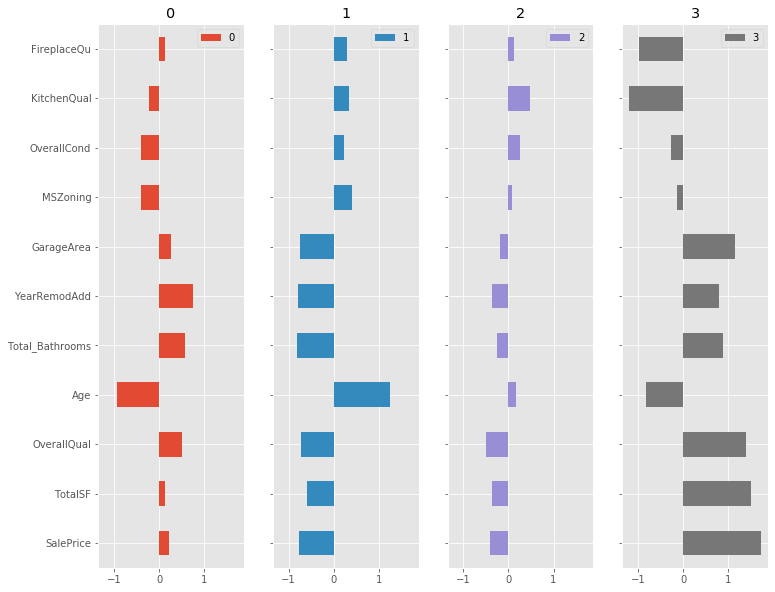

In [144]:
cluster_mean[1:].plot(figsize=(12,10), kind="barh" , subplots=True, layout=(1, 4) , sharey=True)

### 主成分分析を行う

#### 主成分分析用のライブラリをインポートする

リスト4.105　PCAパッケージのインポート

In [145]:
from sklearn.decomposition import PCA

#### 標準化したデータに対して主成分分析を行う

リスト4.106　主成分の数を指定

In [146]:
pca = PCA(n_components=2)
house_pca = pca.fit(train_scaled).transform(train_scaled)

In [147]:
house_pca

array([[ 2.64787423, -1.14274333],
       [ 0.59160484, -0.80163732],
       [ 3.27273499, -0.86695645],
       ...,
       [ 1.78389829,  3.57962252],
       [-3.03539318, -0.99023265],
       [-0.66050633, -1.19928913]])

#### 出力結果をDataFrame形式に変換してもとのDataFrameと結合する

リスト4.107　出力結果をDataFrame形式に変換してもとのDataFrameと結合

In [148]:
house_pca_df = pd.DataFrame(house_pca)
house_pca_df.columns = ["pca1","pca2"]

In [149]:
train_scaled_df = pd.concat([train_scaled_df, house_pca_df], axis=1)

In [150]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,km_cluster,pca1,pca2
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795,0,2.647874,-1.142743
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882,2,0.591605,-0.801637
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584,0,3.272735,-0.866956
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767,1,-1.522228,2.171157
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721,3,5.718597,0.948546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076,0,1.340956,-0.241171
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037,2,1.782666,0.841906
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364,0,1.783898,3.579623
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431,2,-3.035393,-0.990233


#### 主成分分析の結果を可視化する

リスト4.108　主成分分析の結果を可視化

In [151]:
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

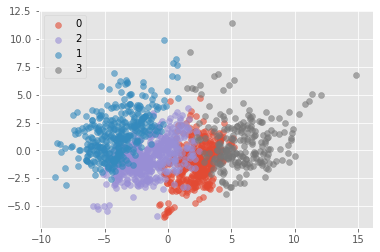

In [152]:
for cl in train_scaled_df['km_cluster'].unique():
    plt.scatter(train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca1'], train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca2'], label=cl, c=my_colors[cl], alpha=0.6)
plt.legend()
plt.show()

リスト4.109　見やすいように転置（行と列を変換）

In [153]:
pca_comp_df = pd.DataFrame(pca.components_,columns=train_scaled_df.drop(["km_cluster","pca1","pca2"],axis=1).columns).T
pca_comp_df.columns = ["pca1","pca2"]

In [154]:
pca_comp_df

,pca1,pca2
MSSubClass,-0.007451,-0.045197
MSZoning,-0.067692,0.062006
LotFrontage,0.089335,0.138855
LotArea,0.084628,0.168670
Street,0.010013,0.010760
...,...,...
Age,-0.197903,0.246229
TotalSF,0.218012,0.188240
Total_Bathrooms,0.189083,0.029206
hasPorch,0.091475,0.031042


## 4.12　追加分析②ハイクラスな家の条件を分析・可視化する

### 決定木で可視化する

#### SalePriceの分布を確認する

リスト4.110　SalePriceの分布を確認

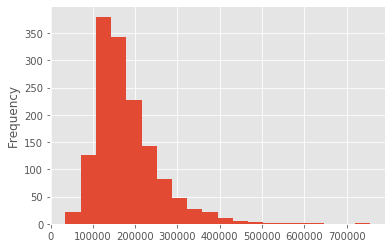

In [155]:
train_df_le['SalePrice'].plot.hist(bins=20)

In [156]:
train_df_le['SalePrice'].describe()

count      1445.000000
mean     179072.294118
std       75905.045476
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      213000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### 上位10%の価格を調べる

リスト4.111　上位10%の価格を確認

In [157]:
train_df['SalePrice'].quantile(0.9)

278000.0

#### ハイクラスな家を表す変数を追加する

リスト4.112　high_class変数を追加

In [158]:
train_df_le.loc[train_df["SalePrice"] >= 278000, "high_class"] = 1

リスト4.113　条件を満たさないものを0とする

In [159]:
train_df_le["high_class"] = train_df_le["high_class"].fillna(0)

In [160]:
train_df_le.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,high_class
0,1,60,3,65.0,8450,1,3,3,0,4,...,8,4,208500.0,0,5,2566.0,4.0,1,12.247694,0.0
1,2,20,3,80.0,9600,1,3,3,0,2,...,8,4,181500.0,0,31,2524.0,3.0,1,12.109011,0.0
2,3,60,3,68.0,11250,1,0,3,0,4,...,8,4,223500.0,0,7,2706.0,4.0,1,12.317167,0.0
3,4,70,3,60.0,9550,1,0,3,0,0,...,8,0,140000.0,0,91,2473.0,2.0,1,11.849398,0.0
4,5,60,3,84.0,14260,1,0,3,0,2,...,8,4,250000.0,0,8,3343.0,4.0,1,12.429216,0.0


#### 決定木を可視化するためのライブラリをインストールする

In [ ]:
!pip install pydotplus

#### ライブラリをインポートする

リスト4.115　ライブラリのインポート

In [161]:
from sklearn import tree
import pydotplus
from six import StringIO

#### 重要度の高い変数に絞る

リスト4.116　tree_xとtree_yを指定

In [162]:
tree_x = train_df_le[["TotalSF","OverallQual","Age","GrLivArea","GarageCars","Total_Bathrooms","GarageType",
"YearRemodAdd","GarageArea","CentralAir","MSZoning","OverallCond","KitchenQual","FireplaceQu","1stFlrSF"]]
tree_y = train_df_le[["high_class"]]

#### 深さを指定して決定木を作成する

リスト4.117　決定木の作成

In [163]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(tree_x, tree_y)

#### 決定木の出力結果を確認する

リスト4.118　決定木の出力結果を確認

In [164]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names=tree_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

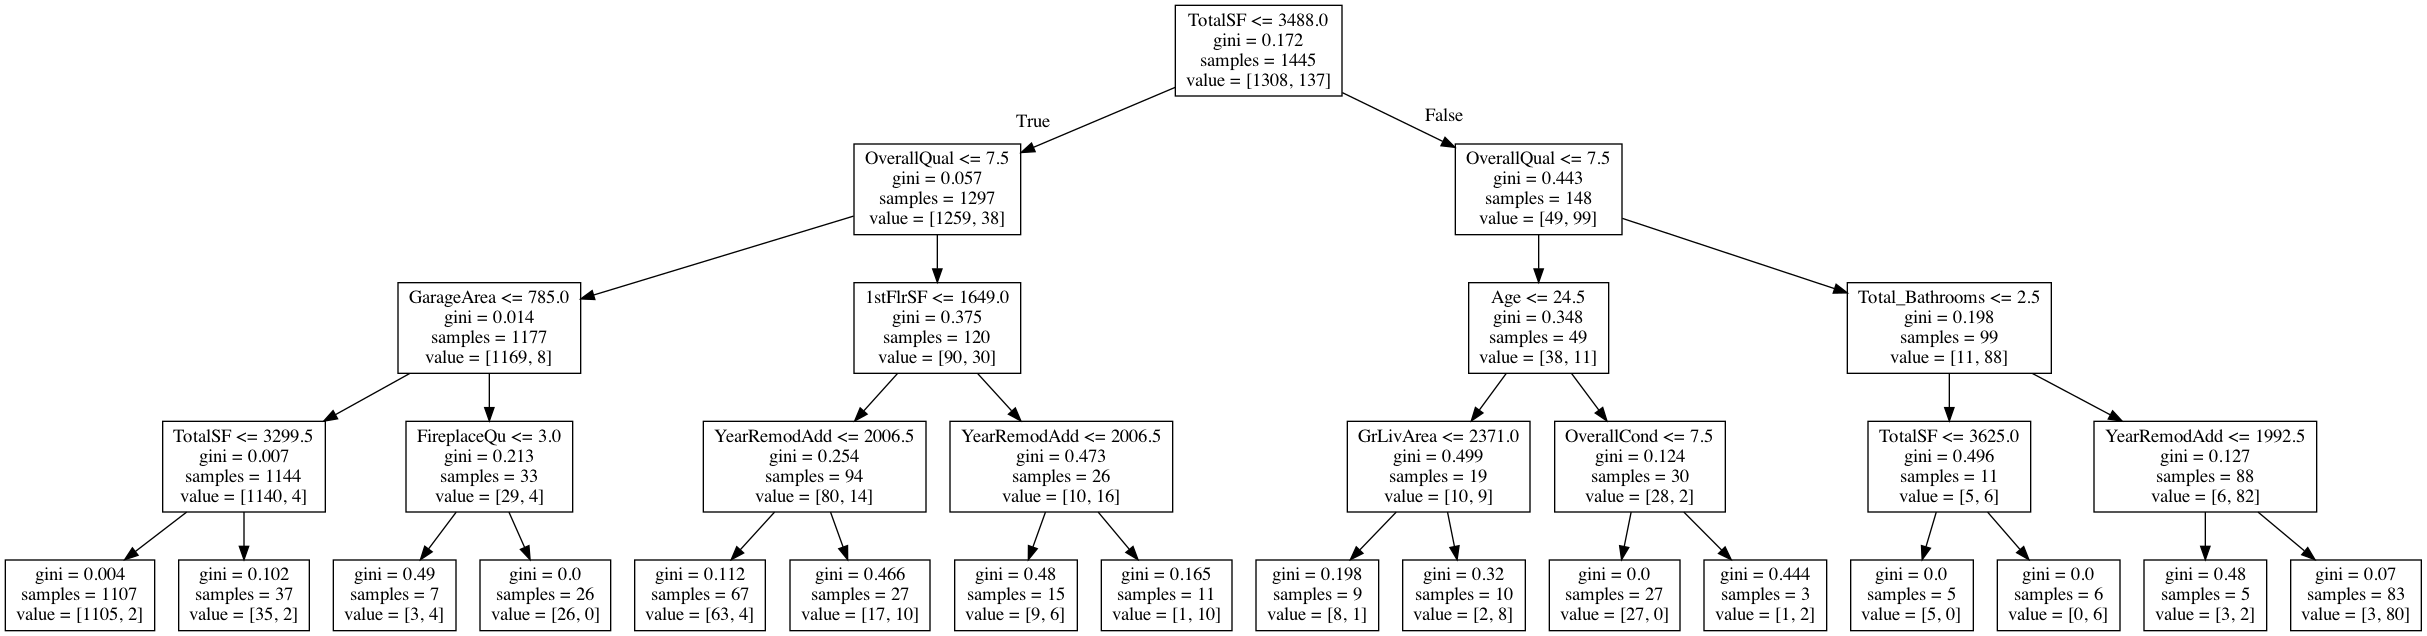

In [165]:
from IPython.display import Image
Image(graph.create_png())